# Fruit Classification

Greg Trunz

<b>Overview:</b> This notebook has two objectives. The narrow objective is to develop a machine learning model that can accurately classify fruit types using a set of predictors that includes weight, volume, and image data. The broad objective is to  promote understanding -- my own and others' -- of important machine learning concepts and tools. To further the latter objective and make the notebook as accessible as possible, I have provided brief explanations of key ideas throughout the notebook and, where applicable, links to illustrative examples and references located at the end of the notebook.

The notebook touches upon a number of important aspects of machine learning, including exploratory data analysis and visualization, data transformations such as scaling and Principal Component Analysis (PCA), model hyperparameter tuning with cross-validation, pipelines to prevent data leakage, evaluation against a hold-out testing set, confusion matrices, and more. It experiments with three basic but widely-used approaches to classification, including k-nearest neighbors (KNN), decision tree, and random forest algorithms. Random forest achieves the highest accuracy, with a mean cross-validation accuracy of about 97 percent and a testing accuracy of 100 percent.  

<b>About the Data:</b> I developed the dataset used in this notebook as a resource for exploring and learning about various data science principles and techniques, particularly those related to machine learning. It was inspired by a premise I would sometimes use when friends would ask me to explain machine learning. I would tell them to imagine a fruit-sorting machine that works on a fruit-processing line, in which each type of fruit must be processed differently. The machine's job is to take a set of measurements for each fruit, use these to determine the type of fruit, and then based on this determination, send the fruit along to the appropriate processing steps. The machine has instruments to measure a fruit's weight and volume, and to take close-up images of each fruit. The role of machine learning in this scenario would be to "train" the machine to accurately identify the fruit type based on the information it collects by building mathematical models around a given set of data in which the fruit type is provided to the machine. These models can then be used to predict the fruit type based on the machine's measurements when the fruit type is not provided. One day, while browsing the produce section of my local grocery store, I decided to take this example a step further and see what it would be like to train a fruit-sorting machine.

This dataset consists of 400 fruits of 10 different types, each with 28,229 variables (or features), including:

 - `id`: The fruit's unique numeric identifier.
 - `type`: The type of fruit (e.g., apple). 
 - `subtype`: The subtype of fruit, if applicable (e.g., honeycrisp). (Note: We will pretend this variable does not exist for this notebook's purposes).
 - `wt_g`: The weight of the fruit in grams.
 - `vol_ml`: The volume of the fruit in milliliters.
 - Color attributes `r_i_j, g_i_j, b_i_j`: Red, green, and blue (RGB) variables for each pixel in a 84 x 112 image of the fruit. The values r, g, and b represent a pixel's red, green, and blue values, respectively. The row value of the pixel is represented by $i \in \text{{0, 1, ..., 83}}$, and the column value of the pixel is represented by $j \in \text{{0, 1, ..., 111}}$.



The first code cell below imports various packages, libraries, and modules that will be used throughout the rest of the notebook.

In [1]:
#data storage, transformations, pre-processing, and exploratory stats
import pandas as pd
import numpy as np
from scipy import stats
import re
import itertools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, ColumnDataSource, Band, Legend
from bokeh.layouts import row, column
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#machine learning
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#toy data example module
from toy import *

## Import Data

We can now import the data, and preview it.

In [2]:
#import dataset
filepath = 'data.csv'
data = pd.read_csv(filepath)

#preview the data
print('Dataset preview:')
display(data.head())
print('Shape: {}'.format(data.shape))

Dataset preview:


id        type     subtype  wt_g  vol_ml  r_0_0  g_0_0  b_0_0  r_0_1  \
0   0  grapefruit         NaN   403     550    229    132     92    230   
1   1     avocado        hass   172     175    242    237    216    242   
2   2       apple  honeycrisp   168     200    190    148     76    194   
3   3       apple  honeycrisp   163     200    211    126     91    214   
4   4     avocado        hass   202     200    203    196    178    206   

   g_0_1  ...  b_83_108  r_83_109  g_83_109  b_83_109  r_83_110  g_83_110  \
0    133  ...        47       151        79        46       150        77   
1    239  ...       130       192       181       164       204       196   
2    154  ...        67       163       102        63       163       104   
3    127  ...        58       174        90        58       173        91   
4    198  ...       164       244       243       223       255       255   

   b_83_110  r_83_111  g_83_111  b_83_111  
0        45       145        71        39  
1       178       160       152       133  
2        65       167       115        74  
3        59       180       104        70  
4       241       253       255       241  

[5 rows x 28229 columns]

Shape: (400, 28229)


## Train-Test Split

We then randomly split the data into a <a href = "https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets">training set and a testing set</a>. Our models use the training set to "learn" about relationships between <i>predictor variables</i> and the <i>target variable</i> that we are trying to predict. In this case, the target variable is the fruit's `type` -- more generically called the "class" in a classification context. The models use these learned patterns to predict the target based on predictor variables for "new" fruits that the model was never exposed to when it was being trained. The testing set serves as the "new" data and is used to evaluate model performance. 

The reason we evaluate models based on a separate set of data not used for training is because it is possible for a model to learn from random noise in the training data that improves its performance on that particular set of data, but does not generalize well for new data. In such cases, the model is said to be <a href="https://en.wikipedia.org/wiki/Overfitting">overfit</a>. An overfit model might achieve high accuracy when making predictions for the data used to train it, but poor accuracy when making predictions for new data, so evaluating models on the training data alone is insufficient and can yield overly optimistic assessments of performance. 

In the below cell, we implement a random <a href="https://en.wikipedia.org/wiki/Stratified_sampling">stratified</a> split based on fruit type, with the aim of yielding similar proportions of fruit types for the training and testing sets. The size of the training set is 340 fruits (85 percent), and the size of the testing set is 60 fruits (15 percent).

The reason we are splitting the data so early in the code is that all of the exploratory analysis, which begins next, will only focus on the training data.

In [3]:
#split data into training and testing sets
train_data,test_data,y_train,y_test = train_test_split(data, 
                                                       data['type'],
                                                       test_size = 60, 
                                                       stratify = data['type'], 
                                                       random_state = 0)

The below visualization shows that the proportions of each type are similar for training and testing data, as expected based on the stratified sampling approach. It also shows us the 10 different classes of fruits contained in the data: apples, avocados, bananas, grapefruits, kiwis, lemons, limes, oranges, passionfruits, and pears.

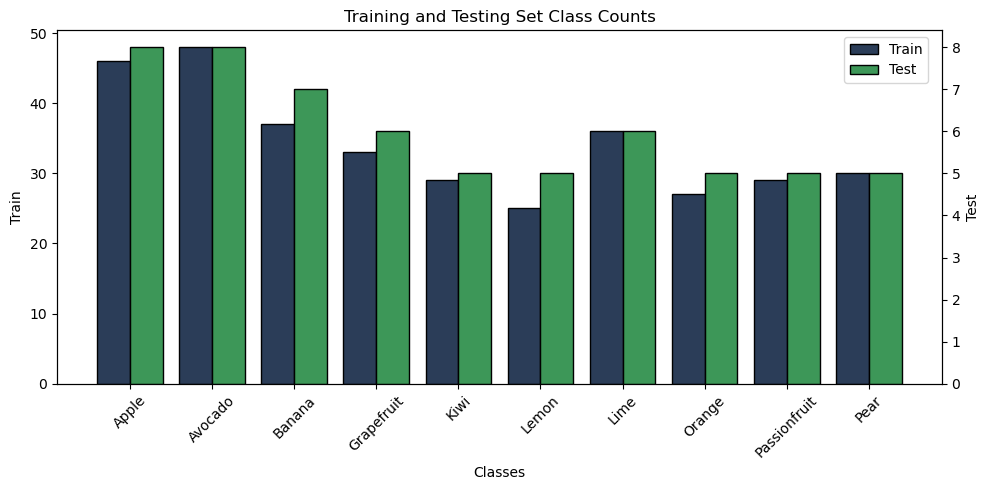

In [4]:
#plot class proportions for training and testing set
sorted_classes = sorted(set(data['type']))
train_counts = [sum(train_data['type']==i) for i in sorted_classes]
test_counts = [sum(test_data['type']==i) for i in sorted_classes]
db = (20/255,  40/255,  70/255, 0.9)
dg = (40/255, 140/255, 70/255, 0.9)

#plot
fig,ax1 = plt.subplots(1,1, figsize = (10,5))
x_locs = [i for i in range(1,len(sorted_classes)+1)]
plt.title('Training and Testing Set Class Counts')
ax1.bar(np.array(x_locs)-0.2, train_counts, width = 0.4, color = db, edgecolor = 'black', label = 'Train')
ax1.set_xticks(x_locs)
ax1.set_xticklabels([i.capitalize() for i in sorted_classes], rotation = 45)
ax1.set_ylabel('Train')
ax1.set_xlabel('Classes')
ax2 = ax1.twinx()
ax2.bar(np.array(x_locs)+0.2, test_counts, width = 0.4, color = dg, edgecolor = 'black', label = 'Test')
ax2.set_ylabel('Test')
fig.legend(bbox_to_anchor = (0.94,0.93))
fig.tight_layout()
plt.show()

In [5]:
#this cell defines certain variables that will be useful throughout the analysis

#weight and volume vars (aka extensive vars)
extensive_vars = ['wt_g','vol_ml']

#get raw image color vars using regex
raw_img_vars = [re.match(r'[rgb]_[0-9]+_[0-9]+',i).group(0)\
                    for i in train_data.columns if bool(re.match(r'[rgb]_[0-9]+_[0-9]+',i))]

#target var
target = 'type'

#all original predictor vars
all_orig_pred_vars = extensive_vars + raw_img_vars

#fruit image dimensions
img_dims = (84,112,3)

#rgb colors
colors = ['red','green','blue']

#rgb plot colors
rd = (230/255, 45/255,  40/255)
gr = (45/255,  170/255, 95/255)
bl = (45/255,  140/255, 200/255)

## Exploratory Data Analysis and Feature Engineering

In this section, we will try to gain some insights about our predictor variables, their relationships with the target variable, and whether they can be transformed or information can be extracted from them (i.e., <a href = "https://en.wikipedia.org/wiki/Feature_engineering">feature engineering</a>) to help our models perform better. The below cell contains a number of custom functions that are helpful for this task, and others that are used in the appendix. 

In [6]:
def view_img(df,idx):
    """Function for plotting an image and printing basic information about it
    Input
    -------
    df: pd.DataFrame
        A set of data from the fruit dataset, such as the training data
    idx: int
        The index of the fruit in df representing its value in the column 'id'
    Returns
    -------
    None
         (Visualization only)
    """
    data = df.copy()
    if idx in data['id']:
        plt.figure(figsize=(4,4))
        img = np.array(data.loc[idx,'r_0_0':])
        img_arr = img.reshape(img_dims).astype(int)
        print('Fruit ID: {}'.format(idx))
        print('Fruit Type: {}'.format(data.loc[idx,target]))
        print('Dimensions: {}'.format(img_dims))
        print('Pixels: {}'.format(img_dims[0]*img_dims[1]))
        print('Total Color Values: {}'.format(np.product(img_dims)))
        print('Image:')
        plt.imshow(img_arr)
        plt.show()
    else:
        print('id does not exist in this dataset.')
        
def view_most_similar(df, fruit_type):
    """Function for getting the most similar images belonging to the same class,
    as measured by L2 distance.
    Input
    -------
    df: pd.DataFrame
        A set of data from the fruit dataset, such as the training data
    fruit_type: string
        The type of fruit shared by all of the images in the comparison; must be a value in the column 'type'
    Returns
    -------
    None
         (Visualization only)
    """
    #check given fruit type is valid
    types = np.array(df[target])
    assert fruit_type in types, 'fruit_type must be in {}'.format(set(types))
    #get all image data for given fruit type
    fruit_type_idx = np.where(types == fruit_type)[0]
    img_data = np.array(df.loc[:,'r_0_0':])
    fruit_type_img_data = img_data[fruit_type_idx]
    #list to store tuples containing each img index, the index of the most similar img, 
    #and the L2 distance between the pair
    min_distance_pairs = []
    #iterate through image data for each fruit of given fruit type
    for i,xi in enumerate(fruit_type_img_data):
        #compute L2 distances between each fruit and every other fruit
        l2_distances = np.linalg.norm(xi - fruit_type_img_data, axis = 1, ord = 2)
        #exclude self by assigning it max value in l2_distances array
        l2_distances[i] = np.max(l2_distances)
        #get index of fruit with closest L2 distance
        min_j = np.argmin(l2_distances)
        #get the distance value
        min_dist = l2_distances[min_j]
        #add tuple to the list
        min_distance_pairs.append((min_dist,i,min_j))
    #sort list and pull first tuple
    min_pair = sorted(min_distance_pairs)[0]
    #get data for these images, reshape it, and display
    img_i_data, img_j_data = fruit_type_img_data[min_pair[1]], fruit_type_img_data[min_pair[2]]
    img_i, img_j = img_i_data.reshape(img_dims), img_j_data.reshape(img_dims)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (6,6), sharey = True)
    ax1.imshow(img_i)
    ax2.imshow(img_j)
    fig.suptitle('Most Similar Images of Class {}'.format(fruit_type.capitalize()), y = 0.68)
    plt.show()

def view_least_similar(df, fruit_type):
    """Function for getting the least similar images belonging to the same class,
    as measured by L2 distance.
    Input
    -------
    df: pd.DataFrame
        A set of data from the fruit dataset, such as the training data
    fruit_type: string
        The type of fruit shared by all of the images in the comparison; must be a value in the column 'type'
    Returns
    -------
    None
         (Visualization only)
    """
    #get all image data for given fruit type
    types = np.array(df[target])
    fruit_type_idx = np.where(types == fruit_type)[0]
    img_data = np.array(df.loc[:,'r_0_0':])
    fruit_type_img_data = img_data[fruit_type_idx]
    #list to store tuples containing each img index, the index of the least similar img, 
    #and the L2 distance between the pair
    max_distance_pairs = []
    #iterate through image data for each fruit of given fruit type
    for i,xi in enumerate(fruit_type_img_data):
        #compute L2 distances between each fruit and every other fruit
        l2_distances = np.linalg.norm(xi - fruit_type_img_data, axis = 1, ord = 2)
        #get index of fruit with furthest L2 distance
        max_j = np.argmax(l2_distances)
        #get the distance value
        max_dist = l2_distances[max_j]
        #add tuple to the list
        max_distance_pairs.append((max_dist,i,max_j))
    #sort list in reverse order and pull first tuple
    max_pair = sorted(max_distance_pairs, reverse = True)[0]
    #get data for these images, reshape it, and display
    img_i_data, img_j_data = fruit_type_img_data[max_pair[1]], fruit_type_img_data[max_pair[2]]
    img_i, img_j = img_i_data.reshape(img_dims), img_j_data.reshape(img_dims)
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (6,6), sharey = True)
    ax1.imshow(img_i)
    ax2.imshow(img_j)
    fig.suptitle('Least Similar Images of Class {}'.format(fruit_type.capitalize()), y = 0.68)
    plt.show()
    
def view_k_class_pairs_most_similar_images(df, k = 2, fruit_types = False):
    """Function for viewing k unique fruit pairs with the two most similar fruit images,
    as measured by L2 distance. Shows the two most similar images for each of the k pairs.
    Input
    -------
    df: pd.DataFrame
        A set of data from the fruit dataset, such as the training data
    k: int
        The number of unique pairs of fruit types to be shown.
    fruit_types: list
        A subset of fruit types to be considered for comparison. If False, will compare all.
    Returns
    -------
    None
         (Visualization only)
    """
    #copy data
    data = df.copy()
    #subset to include given fruit_types if list supplied 
    if fruit_types:
        data = data[data[target].isin(fruit_types)]
    #else compare all fruit types
    else:
        fruit_types = data[target].unique()
    #geta all combinations of fruit types
    fruit_type_combos = [i for i in itertools.combinations(fruit_types, 2)]
    #get all pair similarities using L2 distance from different fruit type combinations
    most_similar_for_pairs = []
    recorded_types = []
    for type_a,type_b in fruit_type_combos:
        a_img_data = np.array(data[data[target]==type_a].loc[:,'r_0_0':])
        b_img_data = np.array(data[data[target]==type_b].loc[:,'r_0_0':])
        ab_similarities = []
        for i,ai in enumerate(a_img_data):
            l2_distances = np.linalg.norm(ai - b_img_data, axis = 1, ord = 2)
            min_j = np.argmin(l2_distances)
            min_dist = l2_distances[min_j]
            ai_img_data = a_img_data[i]
            bj_img_data = b_img_data[min_j]
            ab_similarities.append((min_dist,type_a,type_b,i,min_j,ai_img_data,bj_img_data))
        if not {type_a,type_b} in recorded_types:
            ab_most_similar = sorted(ab_similarities)[0] 
            most_similar_for_pairs.append(ab_most_similar)
        recorded_types.append({type_a,type_b})
    #keep k most similar pairs
    k_most_similar_pairs = sorted(most_similar_for_pairs)[:k]
    #plot results
    for i,most_similar in enumerate(k_most_similar_pairs):
        fig,(ax1,ax2) = plt.subplots(1,2,figsize = (6,6), sharey = True)
        ax1.set_ylabel('Pair {}'.format(i+1))
        ax1.imshow(most_similar[5].reshape(img_dims))
        ax1.set_title(most_similar[1].capitalize())
        ax2.imshow(most_similar[6].reshape(img_dims))
        ax2.set_title(most_similar[2].capitalize())
        if i==0:
            fig.suptitle('Top {} Examples of Similar Image Pairs from Different Classes'.format(k), y = 0.7)
    plt.show()
    
def view_k_classes_least_similar_images(df, k = 2, fruit_types = False):
    """Function for viewing k unique fruit types with the two least similar image pairs,
    as measured by L2 distance. Shows the two least similar images for each of the k fruit types. 
    Input
    -------
    df: pd.DataFrame
        A set of data from the fruit dataset, such as the training data
    k: int
        The number of unique pairs of fruit types to be shown.
    fruit_types: list
        A subset of fruit types to be considered for comparison. If False, will compare all.
    Returns
    -------
    None
         (Visualization only)
    """
    #copy data
    data = df.copy()
    #subset to include given fruit_types if list supplied 
    if fruit_types:
        data = data[data[target].isin(fruit_types)]
    #else compare all fruit types
    else:
        fruit_types = data[target].unique()
    #get all pair similarities using L2 distance comparing only fruits of same type
    least_similar_each_fruit = []
    for ft in fruit_types:
        img_data = np.array(data[data[target]==ft].loc[:,'r_0_0':])
        ft_similarities = []
        for i,xi in enumerate(img_data):
            l2_distances = np.linalg.norm(xi - img_data, axis = 1, ord = 2)
            max_j = np.argmax(l2_distances)
            max_dist = l2_distances[max_j]
            i_img_data = img_data[i]
            maxj_img_data = img_data[max_j]
            ft_similarities.append((max_dist,ft,list(i_img_data),list(maxj_img_data)))
        ft_least_similar = sorted(ft_similarities, reverse = True)[0]
        least_similar_each_fruit.append(ft_least_similar)
    #keep k least similar pairs
    k_least_similar_pairs = sorted(least_similar_each_fruit, reverse = True)[:k]
    #plot results
    for i,least_similar in enumerate(k_least_similar_pairs):
        fig,(ax1,ax2) = plt.subplots(1,2,figsize = (6,6), sharey = True)
        ax1.set_ylabel('Pair {}'.format(i+1))
        ax1.imshow(np.array(least_similar[2]).reshape(img_dims))
        ax1.set_title(least_similar[1].capitalize())
        ax2.imshow(np.array(least_similar[3]).reshape(img_dims))
        ax2.set_title(least_similar[1].capitalize())
        if i==0:
            fig.suptitle('Top {} Examples of Dissimilar Image Pairs from Same Class'.format(k), y = 0.7)
    plt.show()
        
#flattens image array into a row vector
#def flatten(img_arr):
#    return img_arr.reshape((np.product(img_dims)))

#
def color_corr_data(df, color = 'red', n_pixels = 100):
    """Function for getting correlation data for plotting a correlation 
    heatmap between image variables of a given color over a given number of successive pixels, 
    starting in the upper left of the image and moving row-wise along the image.
    Input
    -------
    df: pd.DataFrame
        A set of data from the fruit dataset, such as the training data
    color: string
        Defines the subset of RGB color variables that will be included in the plot. 
        Must be in {'red','green','blue'}.
    n_pixels: int
        The number of image pixel variables to be included in the plot.
    Returns
    -------
    pd.DataFrame
        The data that will be used for the correlation heatmap.
    """
    assert color in {'red','green','blue'}, 'color must be in {}'.format({'red','green','blue'})
    data = df.copy()
    color_letter = {'red':'r','green':'g','blue':'b'}[color]
    n_vars = n_pixels * 3
    all_color_vars = data.loc[:,'r_0_0':].columns[:n_vars]
    color_vars = [i for i in all_color_vars if color_letter in i]
    corr_data = data.loc[:,color_vars].corr()
    return corr_data

def get_color_means(df, color = 'red'):
    """Function for getting the mean color value for a given color for each image in 
    the dataset.
    Input
    -------
    df: pd.DataFrame
        A set of data from the fruit dataset, such as the training data
    color: string
        Defines the subset of RGB color variables that will be included in the mean calculation. 
        Must by in {'red','green','blue'}.
    Returns
    -------
    np.array
        Array containing the mean color values for each row in df. 
        The value at the ith index of the array corresponds to the ith row of the df.
    """
    data = df.copy()
    color_letter = {'red':'r','green':'g','blue':'b'}[color]
    all_color_vars = data.loc[:,'r_0_0':].columns
    color_vars = [i for i in all_color_vars if color_letter in i]
    color_arr = np.array(data[color_vars])
    means = np.mean(color_arr, axis = 1)
    return means

def get_color_means_df(df,colors):
    """Function for getting the mean color value for a given color for each image in 
    the dataset. Calls on get_color_means().
    Input
    -------
    df: pd.DataFrame
        A set of data from the fruit dataset, such as the training data
    colors: list
        Defines the subset of RGB color variables that will be included in the mean calculation. 
        Each element must by in {'red','green','blue'}.
    Returns
    -------
    pd.DataFrame
        A dataset containing the mean color values for all colors included in list colors each row in df. 
        Rows correspond to the rows in the original input df.
    """
    data = df.copy()
    color_mean_data = pd.DataFrame({target:np.array(data[target])})
    for c_i in colors:
        means = get_color_means(data, color = c_i)
        color_mean_data[c_i+'_mean'] = means
    return color_mean_data
    
def plot_pca_explained_variance_ratios(n_components, explained_variance_ratios):
    """Function for plotting PCA explained variance ratios, both individually and cumulatively.
    Input
    -------
    n_components: int
        Specifies the number of PCA components to include in the plot.
    explained_variance_ratios: np.array
        An array of values containing the explained variance ratio for each component. 
    Returns
    -------
    None
         (Visualization only)
    """
    plt.figure(figsize = (10,4))
    plt.grid(alpha = 0.2, zorder = 0)
    plt.bar(range(1,n_components+1),explained_variance_ratios, 
            color = db, zorder = 5)
    plt.plot(range(1,n_components+1),np.cumsum(explained_variance_ratios), linestyle = '--', 
             color = bl, zorder = 5)
    plt.title('Explained Variance\nfor Each Principal Component')
    plt.xlabel('Principal Component')
    plt.xticks(range(1,n_components+1))
    plt.ylabel('Explained Variance Ratio')
    plt.legend(['Cumulative','Individual'])
    plt.show()
    
##########################
#appendix helper functions
##########################
def plot_pca_example1():
    '''Function for plotting PCA example. 
    Plots data with respect to original variables and PCs.
    No input needed. 
    Plots visualizations and returns None.'''
    #get example data
    preds = ['r_55_55','r_55_56']
    X = np.array(train_data[preds])
    y = np.array(train_data[target])
    #scale and apply PCA, store relevant pca data
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(svd_solver = 'full')
    X_pca = pca.fit_transform(X_scaled)
    expl_var_ratios = [str(round(i*100))+'%' for i in pca.explained_variance_ratio_]
    components = pca.components_
    #make plot df
    plot_df = pd.DataFrame(X_scaled, columns = preds)
    plot_df['PC1'] = X_pca[:,0]
    plot_df['PC2'] = X_pca[:,1]
    plot_df[target] = np.array(train_data[target])
    #plot original data with PCA new coordinate system
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (10,4))
    sns.scatterplot(x = preds[0], y = preds[1], hue = target, hue_order = sorted_classes,
                    data = plot_df, ax = ax1, alpha = 0.2, legend = None)
    ax1.set_title('Original Data')
    ax1.arrow(0, 0, components[0][0], components[0][1], color = 'black', linewidth = 5, alpha = 1)
    ax1.text(components[0][0]*2-0.7,components[0][1]*2+0.8,s = 'PC1 ({})'.format(expl_var_ratios[0]),
             color = 'black',alpha = 1)
    ax1.arrow(0, 0, components[1][0], components[1][1], color = 'black', linewidth = 5, alpha = 1)
    ax1.text(components[1][0]*1.2,components[1][1],s = 'PC2 ({})'.format(expl_var_ratios[1]),
             color = 'black',alpha = 1)
    ax1.set_xlabel('{} (scaled)'.format(preds[0]))
    ax1.set_ylabel('{} (scaled)'.format(preds[1]))
    #plot data with respect to 1st PC
    sns.kdeplot(x = 'PC1', fill = 'true', hue = target, hue_order = sorted_classes, 
                data = plot_df, ax = ax2, legend = None)
    ax2.set_title('Data With Respect to PC1')
    ax2.set_xlabel('PC1')
    sns.kdeplot(x = 'PC2', fill = 'true', hue = target, hue_order = sorted_classes, 
                data = plot_df, ax = ax3)
    ax3.set_title('Data With Respect to PC2')
    ax3.set_xlabel('PC2')
    plt.tight_layout()
    plt.show()
    
def plot_pca_example2():
    '''Function for plotting PCA example. 
    Shows correlations between original variables and PCs.
    No input needed. 
    Plots visualizations and returns None.'''
    #get example data
    preds = ['r_55_55','r_55_56']
    X = np.array(train_data[preds])
    y = np.array(train_data[target])
    #scale and apply PCA, store relevant pca data
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(svd_solver = 'full')
    X_pca = pca.fit_transform(X_scaled)
    expl_var_ratios = [str(round(i*100))+'%' for i in pca.explained_variance_ratio_]
    components = pca.components_
    #make plot df
    plot_df = pd.DataFrame(X_scaled, columns = preds)
    plot_df['PC1'] = X_pca[:,0]
    plot_df['PC2'] = X_pca[:,1]
    plot_df[target] = np.array(train_data[target])
    
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,5), sharey = True)
    sns.scatterplot(x = preds[0], y = 'PC1', hue = target, hue_order = sorted_classes,
                    data = plot_df, ax = ax1, alpha = 0.4, legend = None)
    ax1.set_xlabel('{} (scaled)'.format(preds[0]))
    ax1.set_ylabel('PC1')
    r = round(stats.pearsonr(plot_df[preds[0]], plot_df['PC1'])[0], 2)
    ax1.set_title('r={}'.format(r))
    sns.scatterplot(x = preds[1], y = 'PC1', hue = target, hue_order = sorted_classes,
                    data = plot_df, ax = ax2, alpha = 0.4)
    ax2.set_xlabel('{} (scaled)'.format(preds[1]))
    ax2.set_ylabel('PC1')
    r = round(stats.pearsonr(plot_df[preds[1]], plot_df['PC1'])[0], 2)
    ax2.set_title('r={}'.format(r))
    fig.suptitle('PC1 Captures Most Information from Both Original Variables')
    plt.tight_layout()
    plt.show()
    #plot both original variables with respect to second PC
    fig,(ax1,ax2) = plt.subplots(1,2,figsize = (12,5), sharey = True)
    sns.scatterplot(x = preds[0], y = 'PC2', hue = target, hue_order = sorted_classes,
                    data = plot_df, ax = ax1, alpha = 0.4, legend = None)
    ax1.set_xlabel('{} (scaled)'.format(preds[0]))
    ax1.set_ylabel('PC2')
    r = round(stats.pearsonr(plot_df[preds[0]], plot_df['PC2'])[0], 2)
    ax1.set_title('r={}'.format(r))
    sns.scatterplot(x = preds[1], y = 'PC2', hue = target, hue_order = sorted_classes,
                    data = plot_df, ax = ax2, alpha = 0.4)
    ax2.set_xlabel('{} (scaled)'.format(preds[1]))
    ax2.set_ylabel('PC2')
    r = round(stats.pearsonr(plot_df[preds[1]], plot_df['PC2'])[0], 2)
    ax2.set_title('r={}'.format(r))
    fig.suptitle('PC2 Captures Much Less')
    plt.tight_layout()
    plt.show()

def plot_pca_orig_data():
    '''Function for plotting PCA example. 
    Shows only first plot from plot_pca_example1()
    No input needed. 
    Plots visualizations and returns None.'''
    #get example data
    X = np.array(train_data[['r_0_0','r_0_1']])
    #scale and apply PCA, store relevant pca data
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(svd_solver = 'full')
    X_pca = pca.fit_transform(X_scaled)
    expl_var_ratios = [str(round(i*100))+'%' for i in pca.explained_variance_ratio_]
    components = pca.components_
    #plot original data with PCA now coordinate system
    fig,(ax1) = plt.subplots(1,1,figsize = (4,4), sharey = True)
    ax1.scatter(X_scaled[:,0], X_scaled[:,1], color = bl, alpha = 0.3)
    ax1.set_title('Original Data')
    ax1.arrow(0, 0, components[0][0], components[0][1], color = rd, linewidth = 5, alpha = 1)
    ax1.text(components[0][0]*2-1.2,components[0][1]*2+0.8,s = 'PC1 ({})'.format(expl_var_ratios[0]),color = rd,alpha = 1)
    ax1.arrow(0, 0, components[1][0], components[1][1], color = rd, linewidth = 5, alpha = 1)
    ax1.text(components[1][0]*1.2,components[1][1],s = 'PC2 ({})'.format(expl_var_ratios[1]),color = rd,alpha = 1)
    ax1.set_xlabel('r_0_0 (scaled)')
    ax1.set_ylabel('r_0_1 (scaled)')
    plt.show()


### Predictor Scales

One thing that is often worth exploring is the scales (or range of values) of the predictor variables. This is important because for certain modeling approaches, different scales can implicitly assign different weights to the various predictors. For example, KNN relies on distance metrics to compute similarities between samples, and if a certain predictor has values ranging between, say, $\text{-1,000}$ and $\text{1,000}$, then it will carry far more weight in the distance calculations than another predictor with a range of values between $\text{-1}$ and $\text{1}$, even if the latter predictor is equally if not more important for making predictions. Scaling also needs to be done prior to performing PCA, a dimensionality reduction technique that we will utilize later. (More details on KNN and PCA provided below).

The below visualization shows the scales of several potential predictors. It indicates that the scales for at least a few of them are quite different, and that it would therefore be advisable to scale the data prior to modeling.

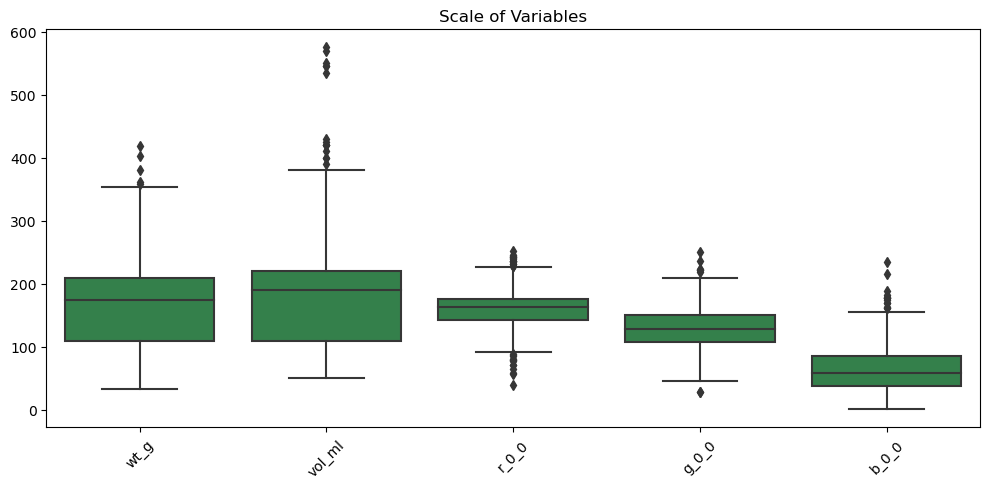

In [7]:
#plot scale of features before scaling
sample_vars = list(train_data.loc[:,'wt_g':'b_0_0'].columns)
plt.figure(figsize = (10,5))
sns.boxplot(data = train_data[sample_vars], color = dg)
plt.xticks(rotation = 45)
plt.title('Scale of Variables')
plt.tight_layout()
plt.show()

### The Image Data: RGB Values

In examining the image data, viewing a few of the actual images can be a useful starting point. The below cell calls the `view_img( )` helper function, defined above, which takes a fruit ID as input, and shows an image of the fruit. Here we see an example of a lime. Apparently, these are up-close images that mostly give us information about general color patterns on a portion of the fruit's surface.  

Fruit ID: 8
Fruit Type: lime
Dimensions: (84, 112, 3)
Pixels: 9408
Total Color Values: 28224
Image:


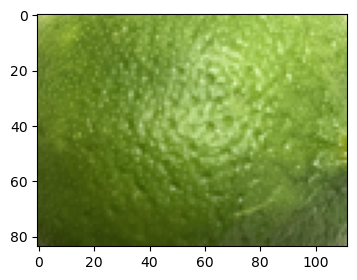

In [8]:
#view a single image
view_img(df = train_data, idx = 8)

It would also be interesting to see how similar and dissimilar some of the images are, both within and across fruit types. This would give us a better idea of some of the simplest and most challenging edge cases that exist in the data. One way to measure similarity for these images would be to treat each image as a single <a href = "https://en.wikipedia.org/wiki/Vector_(mathematics_and_physics)">vector</a> of data, and calculate the L2 (a.k.a. <a href='https://en.wikipedia.org/wiki/Euclidean_distance'>Euclidean</a> or straight-line) distance between each pair of vectors. The smaller the distance between the two vectors, the more similar we might say they are.

The below cell uses the `view_most_similar( )` and `view_least_similar( )` functions, defined above. They show the two most similar and least similar images for a particular fruit type, respectively. Here we apply each to the passionfruit class as an example. Apparently, some passionfruits appear almost identical, and some look like they could be different fruit types altogether.

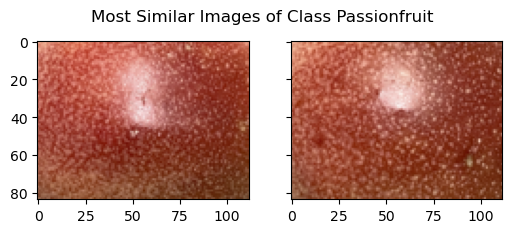

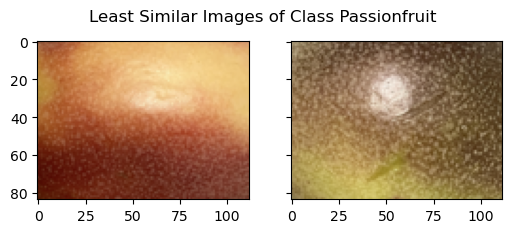

In [9]:
#view most similar and least similar fruits within a given class of fruit
view_most_similar(df = train_data, fruit_type = 'passionfruit')
view_least_similar(df = train_data, fruit_type = 'passionfruit')

The below code cell calls our `view_k_class_pairs_most_similar_images( )` helper function, which traverses multiple classes of fruits, measures similarities in images across various class pairs, and shows K unique pairs of different fruits types with the most similar two images. Here, we set K=5 and can see some very close similarities, particularly between oranges, lemons, grapefruits, and bananas. Such of these cases may pose challenges for our models -- indeed, many humans might find it difficult to identify correct fruit types based on these images alone. 

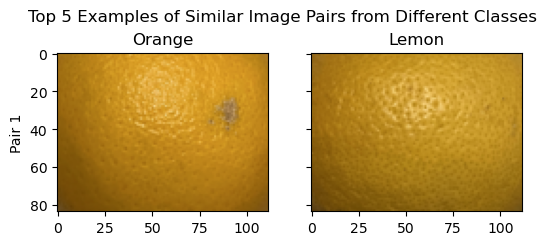

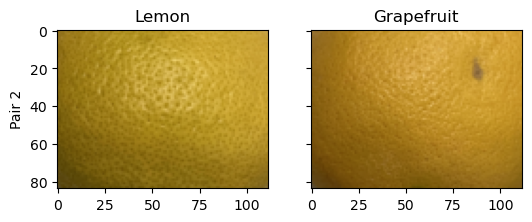

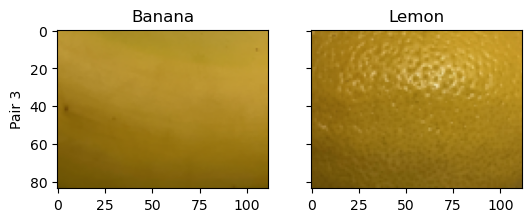

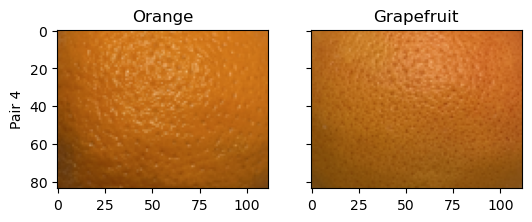

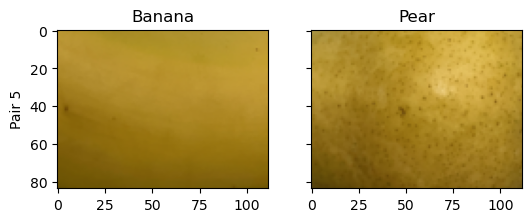

In [10]:
#view top k most similar images from different classes
view_k_class_pairs_most_similar_images(df = train_data, k = 5, fruit_types = False)

Similarly, we can examine examples of within-class differences across various fruit types. The below cell calls our helper function `view_k_classes_least_similar_images( )`. It shows examples of five fruit types having the two least similar images. Here we see that some fruits of the same type can present very different color patterns. This may also present difficulties. For example, the red apple and red pear appear to bear more similar than their green counterparts of the same fruit type.

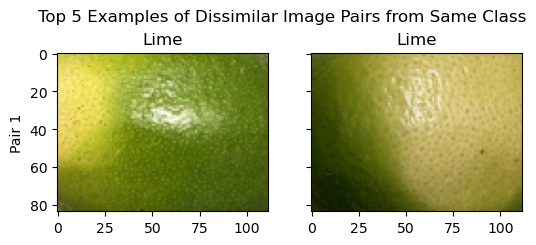

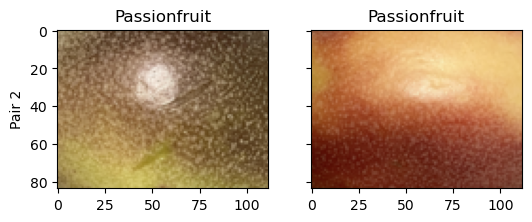

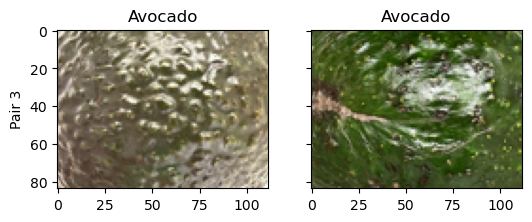

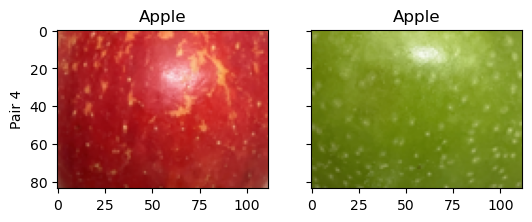

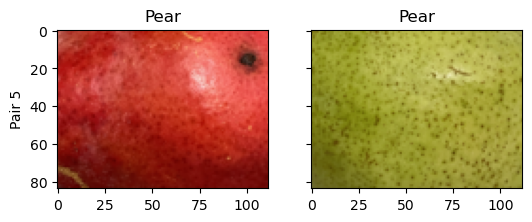

In [11]:
#view top least similar images from same class
view_k_classes_least_similar_images(df = train_data, k = 5, fruit_types = False)

#### High Dimensionality

Another potential hurdle that we face with this data is the issue of <a href="https://en.wikipedia.org/wiki/High-dimensional_statistics">high dimensionality</a> -- i.e., a large number of potential predictor variables. In this dataset, each image is $83 \times 112 = 9,408$ pixels. With each pixel containing three color values -- red, green, and blue -- this amounts to $28,224$ variables per image. In general, high-dimensional data can introduce a number of pitfalls in machine learning. For example, the data may contain many irrelevant variables, which create noise and obscure meaningful patterns that are more useful for prediction. If a large proportion of the variables exhibit high <a href="https://en.wikipedia.org/wiki/Multicollinearity">multicollinearity</a>, then many are likely redundant, and can make machine learning more computationally expensive without adding much predictive value. The task, then, is to try to extract from these variables the information that is likely most important for making prediction, while discarding that which is not. 

Examining correlations between our predictors can help reveal the extent to which we might be able to combine them into lower dimensional but still meaningful representations. The idea is that if there is strong correlation among many of the features, a large fraction of them probably provide little added value individually, and we can try to reduce the number of features that we use without losing too much useful information, either by selecting a few key features or aggregating them together into a lower dimensional representation. 

The below correlation plots are interesting. They show correlations in values for the three colors among the first five row of image pixels (showing more rows would yield a similar pattern). Darker shades of blue indicate strong correlation. The overall pattern therefore reveals at least three things: 1) There is indeed substantial multicollinearity in this data; 2) Pixels that are closer to each other in proximity tend to be more strongly correlated; 3) The red color values generally seem more correlated with each other on average relative to other colors, followed by green then blue. 

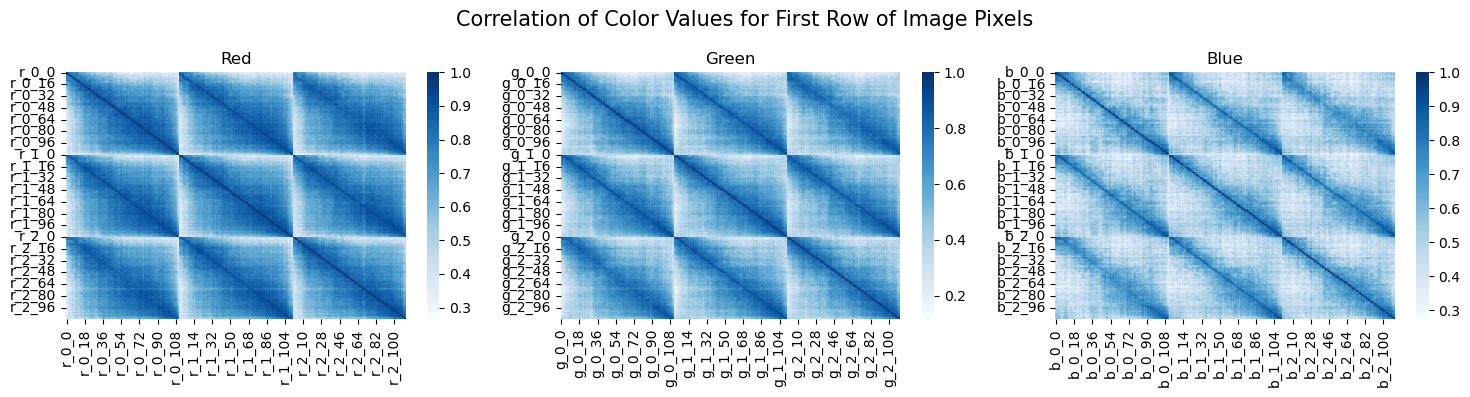

In [12]:
#corr plots for each color variable for the first row of images
rows = 3
n = img_dims[1] * rows
fig,ax = plt.subplots(1,3, figsize = (15,4))
for axi,ci in zip(ax,colors):
    corr_data = color_corr_data(train_data, color = ci, n_pixels = n)
    sns.heatmap(corr_data, ax = axi, cmap = 'Blues')
    axi.set_title(ci.capitalize())
fig.suptitle('Correlation of Color Values for First Row of Image Pixels'.format(n), size = 15)
fig.tight_layout()

The below scatterplots reinforce this point. They show that the relationship for each color value between the first image pixel (upper left) and the pixel immediately to the right of it. There is a strong linear relationship, and the relationship appears to be fairly uniform across different classes of fruits. All of this indicates that it would be plausible and potentially worthwhile to pursue methods for reducing these variables.

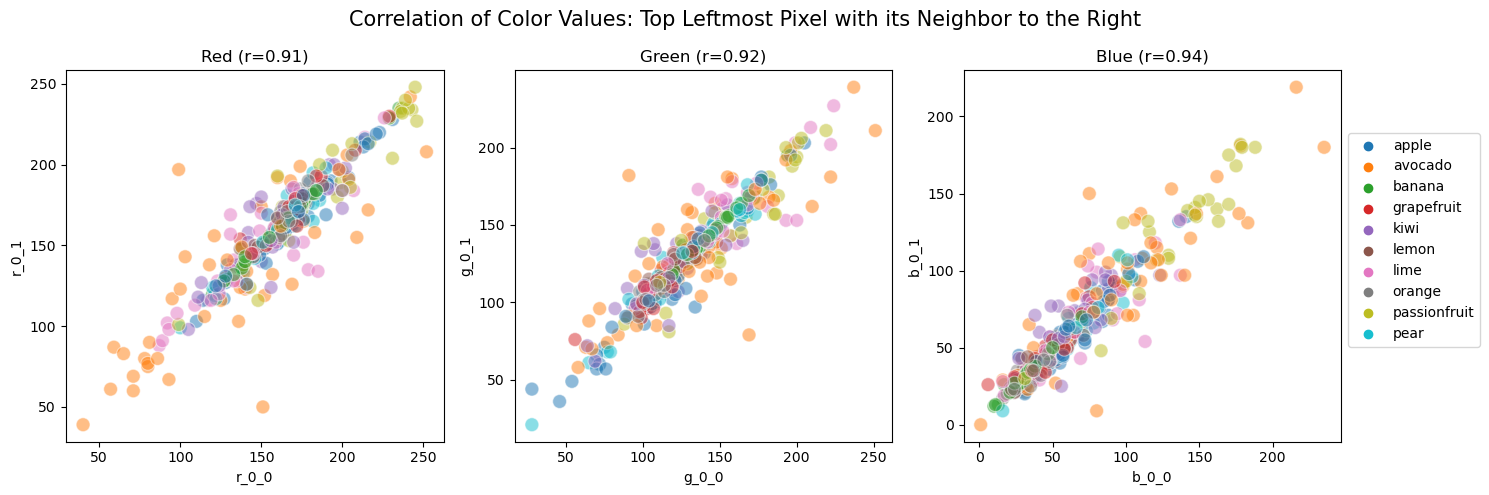

In [13]:
#show example of color value correlating with the next pixel for each color
fig,ax = plt.subplots(1,3, figsize = (15,5))
for i,(c_i,ax_i) in enumerate(zip(colors,ax)):
    r = round(stats.pearsonr(train_data['{}_0_0'.format(c_i[0])], 
                             train_data['{}_0_1'.format(c_i[0])])[0], 2)
    if i<len(ax)-1:
        sns.scatterplot(x = '{}_0_0'.format(c_i[0]), y = '{}_0_1'.format(c_i[0]), hue = target, 
                            hue_order = sorted_classes, legend = False,
                            s = 100, alpha = 0.5, data = train_data, ax = ax_i)
    else:
        sns.scatterplot(x = '{}_0_0'.format(c_i[0]), y = '{}_0_1'.format(c_i[0]), hue = target, 
                        hue_order = sorted_classes,
                        s = 100, alpha = 0.5, data = train_data, ax = ax_i)
        ax_i.legend(bbox_to_anchor = (1,.85))
    ax_i.set_title(c_i.capitalize() + ' (r=' + str(r) + ')')  
fig.suptitle('Correlation of Color Values: Top Leftmost Pixel with its Neighbor to the Right', size = 15)
fig.tight_layout()
plt.show()

#### Dimensionality Reduction: Averaging

One basic way to reduce the image data given the above information might be to just calculate the mean RGB color values for each fruit image, thereby reducing the number of image predictors down to just three. 

The below cell visualizes the distributions of each color's average value by fruit type. Ideally, we would like to see very different distributions for each type of fruit, with little overlap. There appear to be some clear and probably useful patterns that could be used to distinguish between some fruit types but not others. For example, it would be fairly easy to distinguish between an orange and an avocado knowing only the average red value, but more difficult to distinguish between a lemon and a banana based on all three of the average color values.

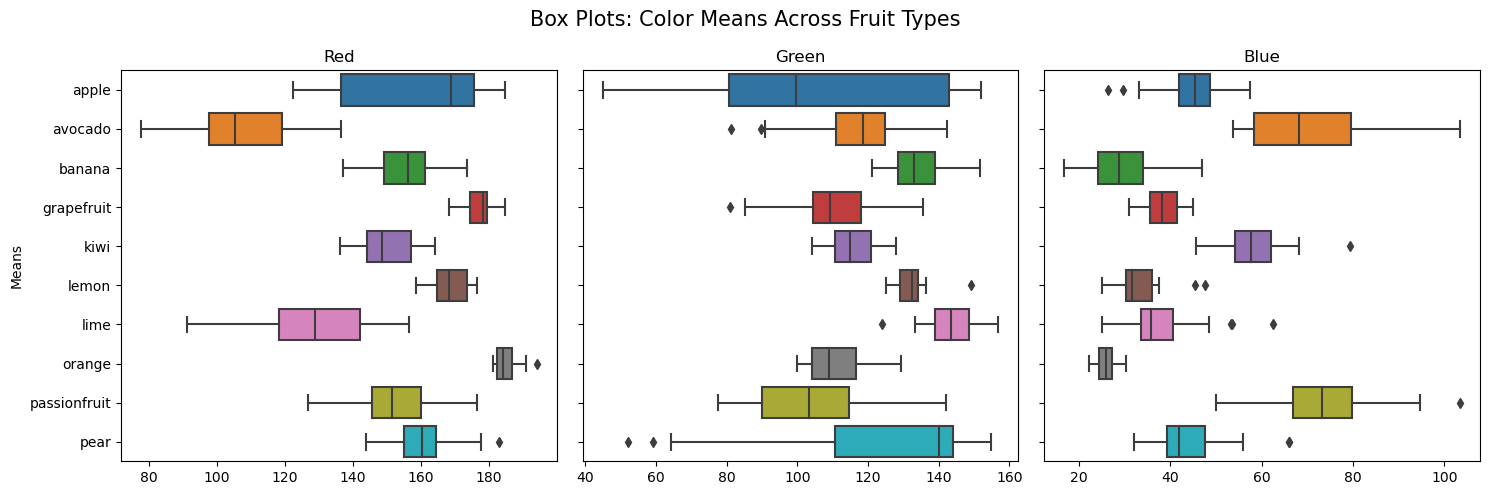

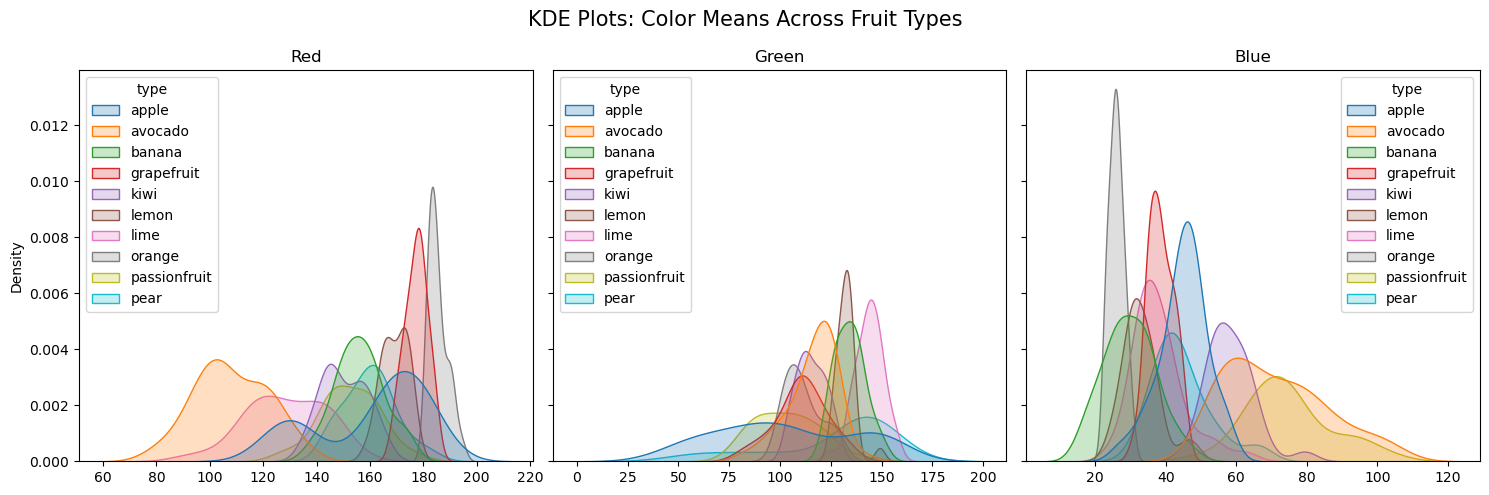

In [14]:
#generate df of color means for each image for visualizations
color_means_data_train = get_color_means_df(train_data,colors)
color_mean_vars = [i for i in color_means_data_train.columns if 'mean' in i]

#box plots
fig,ax = plt.subplots(1,3, figsize = (15,5), sharey = True)
for i,(mean_var_i,ax_i) in enumerate(zip(color_mean_vars,ax)):
    sns.boxplot(y = target, x = mean_var_i, order = sorted_classes,
               data = color_means_data_train, ax = ax_i)
    ax_i.set_xlabel('')
    ax_i.set_title(re.sub('_mean', '', mean_var_i).capitalize())
    if i==0:
        ax_i.set_ylabel('Means')
    else:
        ax_i.set_ylabel(None)
fig.suptitle('Box Plots: Color Means Across Fruit Types', size = 15)
fig.tight_layout()
        
#kde plots
fig,ax = plt.subplots(1,3, figsize = (15,5), sharey = True)
for i,(mean_var_i,ax_i) in enumerate(zip(color_mean_vars,ax)):
    axplot = sns.kdeplot(x = mean_var_i, hue = target, hue_order = sorted_classes, fill = 'true', 
                    data = color_means_data_train, ax = ax_i)
    if i<2:
        sns.move_legend(axplot, 'upper left')
    if i==0:
        ax_i.set_ylabel('Density')
    else:
        ax_i.set_ylabel(None)
    ax_i.set_xlabel('')
    ax_i.set_title(re.sub('_mean', '', mean_var_i).capitalize()) 
fig.suptitle('KDE Plots: Color Means Across Fruit Types', size = 15)
fig.tight_layout()

Scatterplots of the color means show that fruits of the same type generally tend to cluster together when represented in two dimensions -- further evidence of their potential value -- although again there is some notable overlap between certain groups.

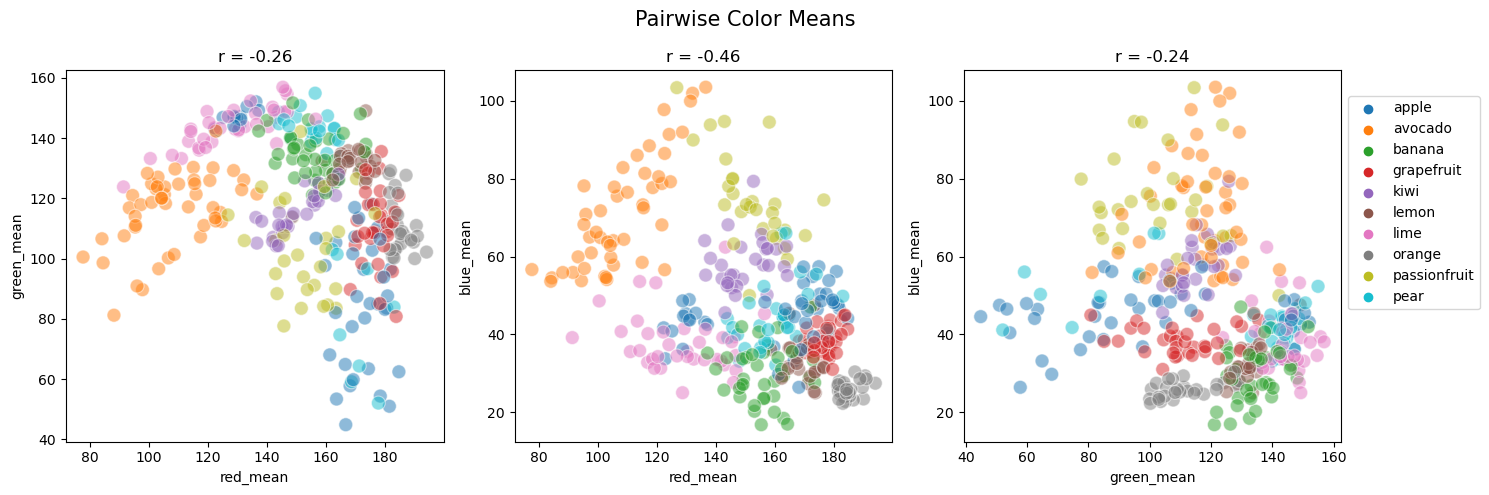

In [15]:
#color means scatterplots
mean_var_combos = [i for i in itertools.combinations(color_mean_vars, 2)]

fig,ax = plt.subplots(1,3, figsize = (15,5))
for i,((var_i,var_j),ax_i) in enumerate(zip(mean_var_combos,ax)):
    r = round(stats.pearsonr(color_means_data_train[var_i], color_means_data_train[var_j])[0], 2)
    if i<len(ax)-1:
        sns.scatterplot(x = var_i, y = var_j, hue = target, hue_order = sorted_classes, 
                        legend = False, s = 100, alpha = 0.5, data = color_means_data_train, ax = ax_i)
    else:
        sns.scatterplot(x = var_i, y = var_j, hue = target, hue_order = sorted_classes, 
                        s = 100, alpha = 0.5, data = color_means_data_train, ax = ax_i)
        ax_i.legend(bbox_to_anchor = (1,.95))
    ax_i.set_title('r = {}'.format(r))
fig.suptitle('Pairwise Color Means', size = 15)
fig.tight_layout()
plt.show()

<a id='pca'></a>
#### Dimensionality Reduction: Principal Component Analysis (PCA)

Another approach to dimensionality reduction, which is commonly used in machine learning applications, is <a href="https://en.wikipedia.org/wiki/Principal_component_analysis">PCA</a>. 

PCA transforms predictor variables into a new coordinate system, yielding a new set of variables that correspond to dimensions, or principal components (PCs) in the new system. The PCs can be ordered based on the amount of explained variance from the original data that they contain. By selecting PCs that account for more explained variance -- which ideally but not necessarily corresponds to useful information -- the hope is to concentrate the most useful information into a smaller number of variables while reducing redundancy and noise. Original variables that are strongly correlated with each other -- implying that they contain similar information and that it may be unnecessary to include both -- tend to have their information combined into common PCs. A basic example of PCA using some of the fruit data is available [here](#pca_ex), and references related to PCA can be viewed [here](#pca_ref).

It should be noted that PCA is not necessarily the best approach to dimensionality reduction, particularly for classification tasks, in part because it is an unsupervised method -- i.e., it does not take the classes of the data into account, as do other approaches such as <a href = "https://en.wikipedia.org/wiki/Linear_discriminant_analysis"> linear discriminant analysis (LDA)</a>. While LDA has clear benefits over PCA, it tends to struggle when the dimensions of the data outnumber the samples, which is the case with this fruit dataset. There are ways to improve LDA to address this issue, but this is beyond the scope of this analysis and for now we will examine what PCA can achieve.

The below cell applies PCA to the image data using Scikit-Learn's <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">PCA</a> class. Prior to implementing PCA, it is important that the data be scaled and zero-centered. The below cell uses Scikit-Learn's <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> class to transform the data, such that variable means are approximately zero and their variances are reduced to one. If they do not have similar scales, features with larger scales will carry greater weight and skew the results of the transformation.

The cell then calls on a helper function defined above to visualize the proportion of variance that each PC explains, both individually and cumulatively. The plot indicates that the first two PCs explain significantly more of the variance than all others individually, but cumulatively only explain less than half of the total variance. One would need to use about 10 PCs to capture at least 70 percent of the variance, and at least 32 PCs to account for at least 80 percent of the variance. While this visualization is useful for revealing a general range of PCs worth exploring, we will ultimately test to see what works best empirically with our models rather than choosing a specific number of PCs in advance.

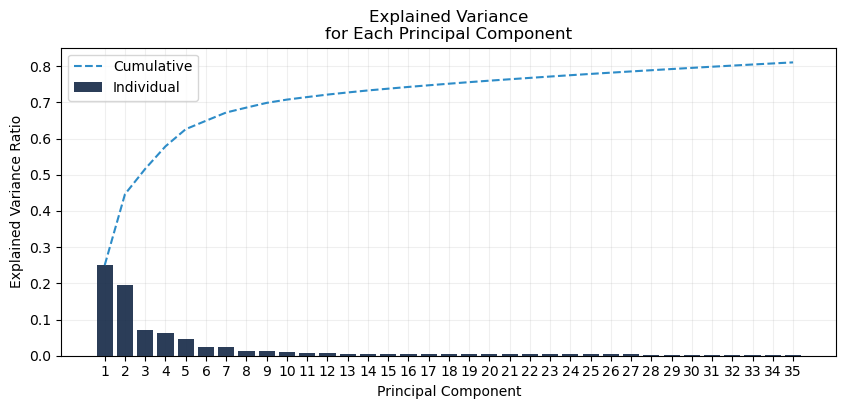

In [16]:
#pca transformation
n_components = 35
all_img_arr = np.array(train_data.loc[:,'r_0_0':])
all_img_arr_scaled = StandardScaler().fit_transform(all_img_arr) 
pca = PCA(n_components = n_components, svd_solver = 'full')
pca_transformation = pca.fit_transform(all_img_arr_scaled)

#plot explained variance
plot_pca_explained_variance_ratios(n_components, pca.explained_variance_ratio_)

The below cell visualizes how the new predictors derived from PCA are distributed for the different fruit types. Here we see that there is a great deal of difference between fruit types for the first two PCs, but the differences start to taper off for the third PC.

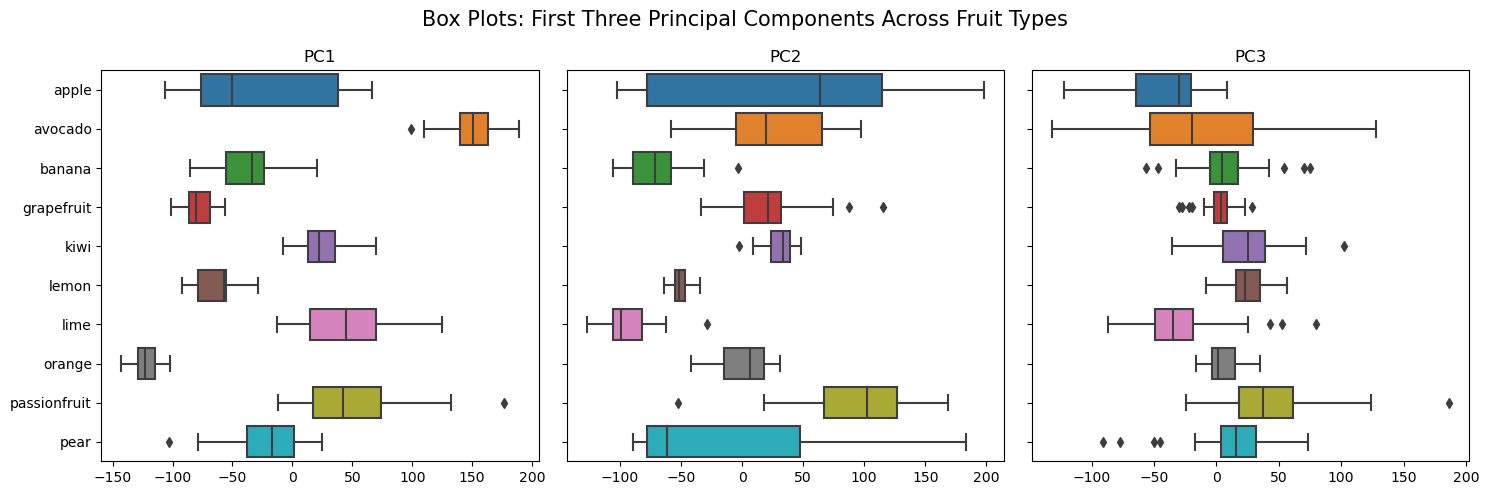

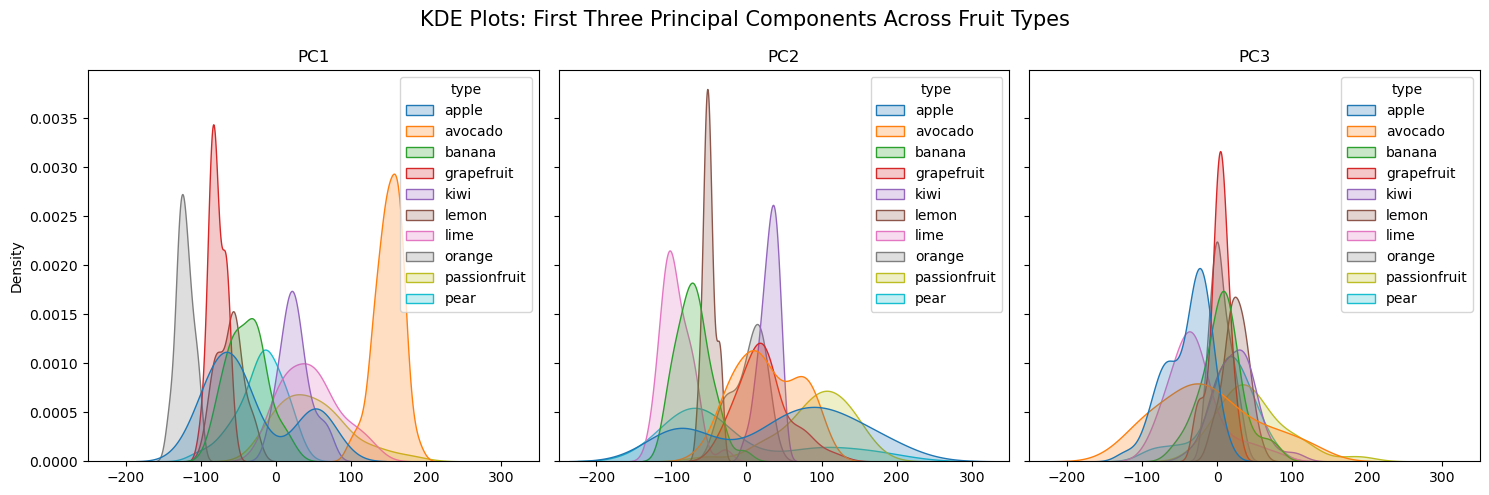

In [17]:
#plot distributions of first three PCs
pca_plot_data = pd.DataFrame(pca_transformation)
pca_plot_data.columns = ['PC{}'.format(i) for i in range(1,n_components+1)]
pca_plot_data[target] = np.array(train_data.loc[:,target])
pc_vars = [i for i in pca_plot_data.columns if 'PC' in i]

#box plots
fig,ax = plt.subplots(1,3, figsize = (15,5), sharey = True)
for i,(pc_i,ax_i) in enumerate(zip(pc_vars[:3],ax)):
    sns.boxplot(y = target, x = pc_i, order = sorted_classes, data = pca_plot_data, ax = ax_i)
    ax_i.set_title(pc_i)
    ax_i.set_xlabel(None)
    ax_i.set_ylabel(None)
fig.suptitle('Box Plots: First Three Principal Components Across Fruit Types', size = 15)
plt.tight_layout()

#kde plots
fig,ax = plt.subplots(1,3, figsize = (15,5), sharey = True)
for i,(pc_i,ax_i) in enumerate(zip(pc_vars[:3],ax)):
    axplot = sns.kdeplot(x = pc_i, hue = target, hue_order = sorted_classes, fill = 'true', data = pca_plot_data, ax = ax_i)
    if i==0:
        ax_i.set_ylabel('Density')
    else:
        ax_i.set_ylabel(None)
    ax_i.set_xlabel('')
    ax_i.set_xlim(-250,350)
    ax_i.set_title(pc_i)
fig.suptitle('KDE Plots: First Three Principal Components Across Fruit Types', size = 15)
fig.tight_layout()
plt.show()


Using scatterplots, we can see that the new predictors are now uncorrelated -- a feature of PCA -- and that fruits of the same type cluster together nicely into largely differentiable groups when mapped along the first PCs, but again this clustering appears to diminish significantly by the third PC.

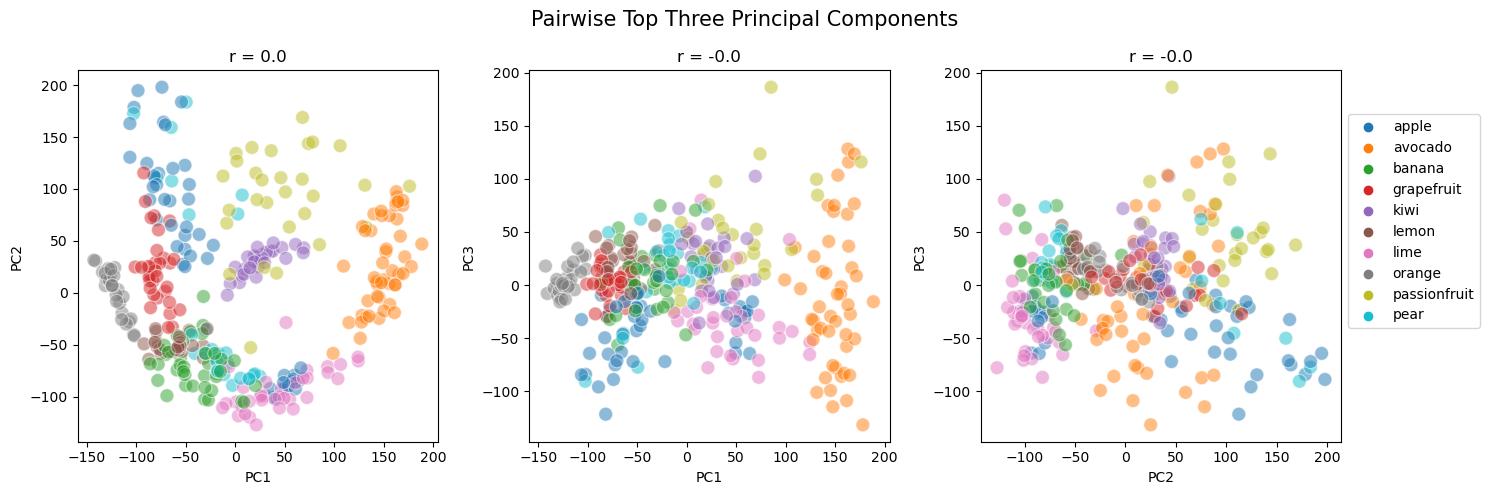

In [18]:
#PCA Scatterplots
pc_scatter_pairs = [(1,2), (1,3), (2,3)]

#plot
fig,ax = plt.subplots(1,3, figsize = (15,5))
for i,(pair_i,ax_i) in enumerate(zip(pc_scatter_pairs,ax)):
    r = round(stats.pearsonr(pca_plot_data['PC{}'.format(pair_i[0])], pca_plot_data['PC{}'.format(pair_i[1])])[0],2)
    if i!=len(ax)-1:
        sns.scatterplot(x = 'PC{}'.format(pair_i[0]), y = 'PC{}'.format(pair_i[1]), hue = target, hue_order = sorted_classes, 
                        legend = False, s = 100, alpha = 0.5, data = pca_plot_data, ax = ax_i)
    else:
        sns.scatterplot(x = 'PC{}'.format(pair_i[0]), y = 'PC{}'.format(pair_i[1]), hue = target, hue_order = sorted_classes, 
                        s = 100, alpha = 0.5, data = pca_plot_data, ax = ax_i)
        ax_i.legend(bbox_to_anchor = (1,.9))
    ax_i.set_title('r = {}'.format(r))
fig.suptitle('Pairwise Top Three Principal Components', size = 15)
plt.tight_layout()

We can also examine associations between the new predictors correspond and our original predictors. This can help make the modeling results more interpretable later. One way to do this is to examine the coefficients used to implement the PCA transformation. Each coefficient is associated with a single original variable and a PC, and they serve as weights when converting the many original variable values of each of the fruits into a single value associated with a particular PC. So, the larger the absolute value of the coefficient, the stronger the relationship between its original variable and its PC. 

The below visualizations show the coefficients for each variable, grouped by RGB colors, in relation to the first two PCs. They indicate that the first PC is most strongly associated with the red variables, and the relationship is negative. In other words, fruits with higher red values would tend to have a lower value for this new predictor. We also see that this new predictor is positively associated with blue and green variables, although the strength of the relationship tends to be weaker. In contrast, the second PC appears to have a negative association with the green variables. The third PC does not seem to correspond to a particular color -- as all three colors exhibit a similar pattern -- but instead to values across different regions of the image.

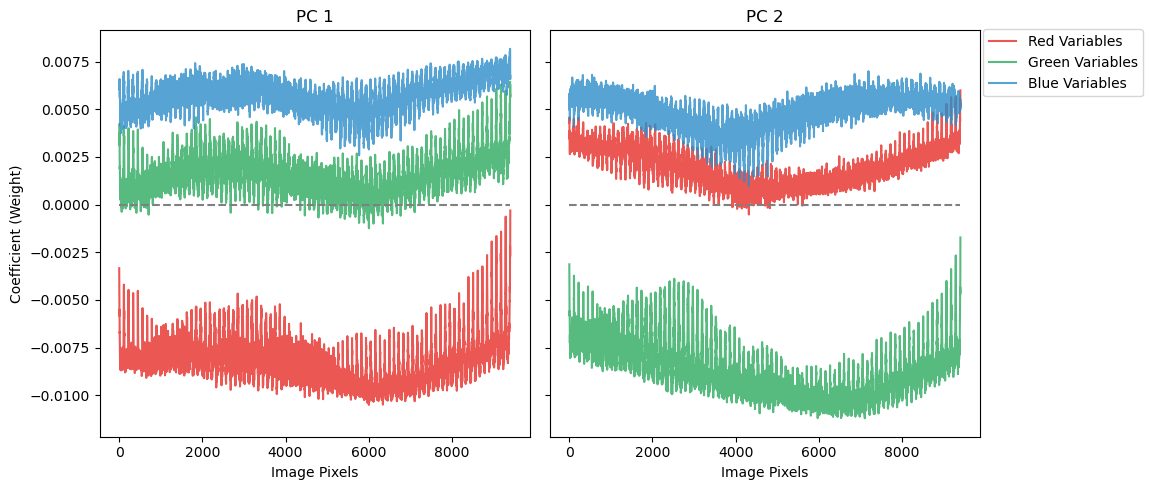

In [19]:
#plotting relationships with original variables
red_var_idx   = [i for i in range(0,28224,3)] 
green_var_idx = [i for i in range(1,28224,3)] 
blue_var_idx  = [i for i in range(2,28224,3)] 

fig,ax = plt.subplots(1,2, figsize = (10,5), sharey = True)
PC = [1,2]
for pc_i,ax_i in zip(PC,ax):
    ax_i.plot(pca.components_.T[red_var_idx, pc_i-1], color = rd, alpha = 0.8, label = 'Red')
    ax_i.plot(pca.components_.T[green_var_idx, pc_i-1], color = gr, alpha = 0.8, label = 'Green')
    ax_i.plot(pca.components_.T[blue_var_idx, pc_i-1], color = bl, alpha = 0.8, label = 'Blue')
    ax_i.set_title('PC {}'.format(pc_i))
    ax_i.hlines(y = 0, xmin = 0, xmax = 28224/3, color = 'gray', linestyle = '--')
    ax_i.set_xlabel('Image Pixels')
    if pc_i==1:
        ax_i.set_ylabel('Coefficient (Weight)')
fig.legend(['Red Variables','Green Variables','Blue Variables'], bbox_to_anchor = (1.155,0.945))
fig.tight_layout()
plt.show()

To convince ourselves of this interpretation, we can directly examine the correlation between the color variables for red and green computed above, and the first two new predictors created by the PCA transformation. Indeed, we see a strong negative association between the mean of the red variables and the first new predictor, and a strong negative association between the mean of the green variables and the second new predictor. So PCA picked up on some similar patterns contained within the color means, although they are not identical, and we can use more than three PCs if needed.

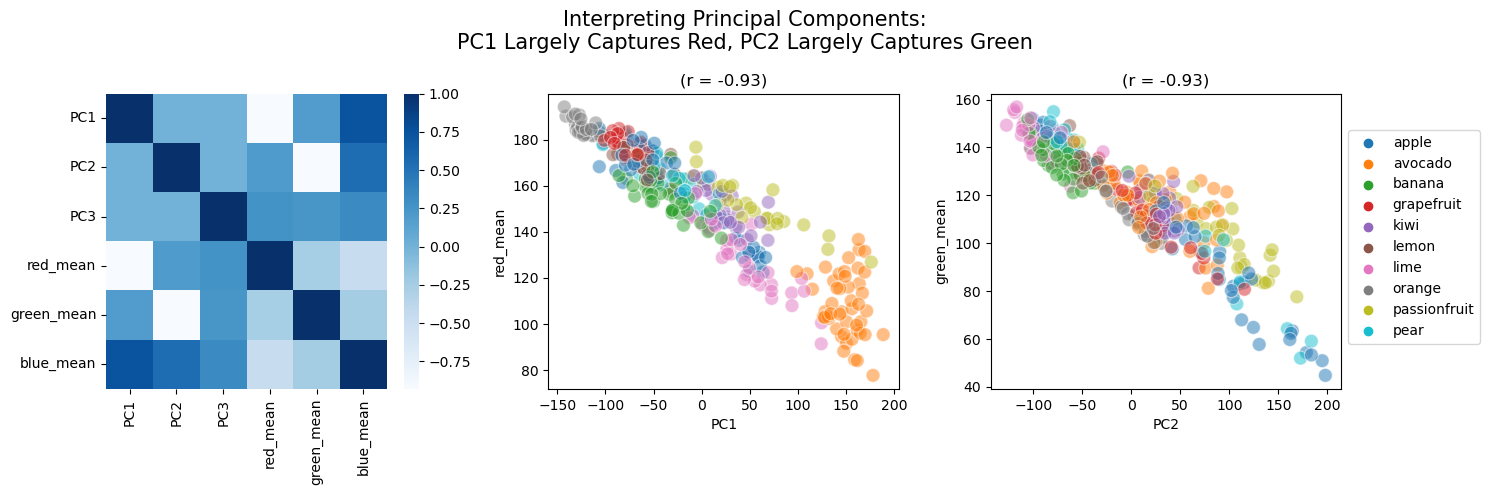

In [20]:
#interpreting the first three PCs with respect to color means
pca_colormean_compare = pd.concat((pca_plot_data.loc[:,:'PC3'],color_means_data_train),axis = 1,ignore_index = True)
pca_colormean_compare.columns = list(pca_plot_data.loc[:,:'PC3'].columns) + list(color_means_data_train.columns)
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))
sns.heatmap(pca_colormean_compare.loc[:,['PC1','PC2','PC3','red_mean','green_mean','blue_mean']].corr(), 
            cmap = 'Blues', ax = ax1)
r = round(stats.pearsonr(pca_colormean_compare['PC1'], pca_colormean_compare['red_mean'])[0], 2)
sns.scatterplot(x = 'PC1', y = 'red_mean', hue = target, hue_order = sorted_classes, 
                        s = 100, alpha = 0.5, data = pca_colormean_compare, ax = ax2, legend = False)
ax2.set_title('(r = {})'.format(r))
r = round(stats.pearsonr(pca_colormean_compare['PC2'], pca_colormean_compare['green_mean'])[0], 2)
sns.scatterplot(x = 'PC2', y = 'green_mean', hue = target, hue_order = sorted_classes, s = 100, alpha = 0.5, 
                data = pca_colormean_compare, ax = ax3)
ax3.set_title('(r = {})'.format(r))
ax3.legend(bbox_to_anchor = (1,0.9))
fig.suptitle('Interpreting Principal Components:\nPC1 Largely Captures Red, PC2 Largely Captures Green', size = 15)
fig.tight_layout()

### The Extensive Predictors: Weight and Volume

In addition to the image data, we also have data on fruit weight and volume. (In physics, these fall under the category of <a href="https://en.wikipedia.org/wiki/Intensive_and_extensive_properties#Extensive_properties">extensive properties</a>, so we group them in the `extensive_vars` list). The below visualizations indicate that these predictors will likely be very useful in certain cases. For example, although the color distributions of lemons and grapefruits tended to overlap, there is are greater differences between their sizes and weights.

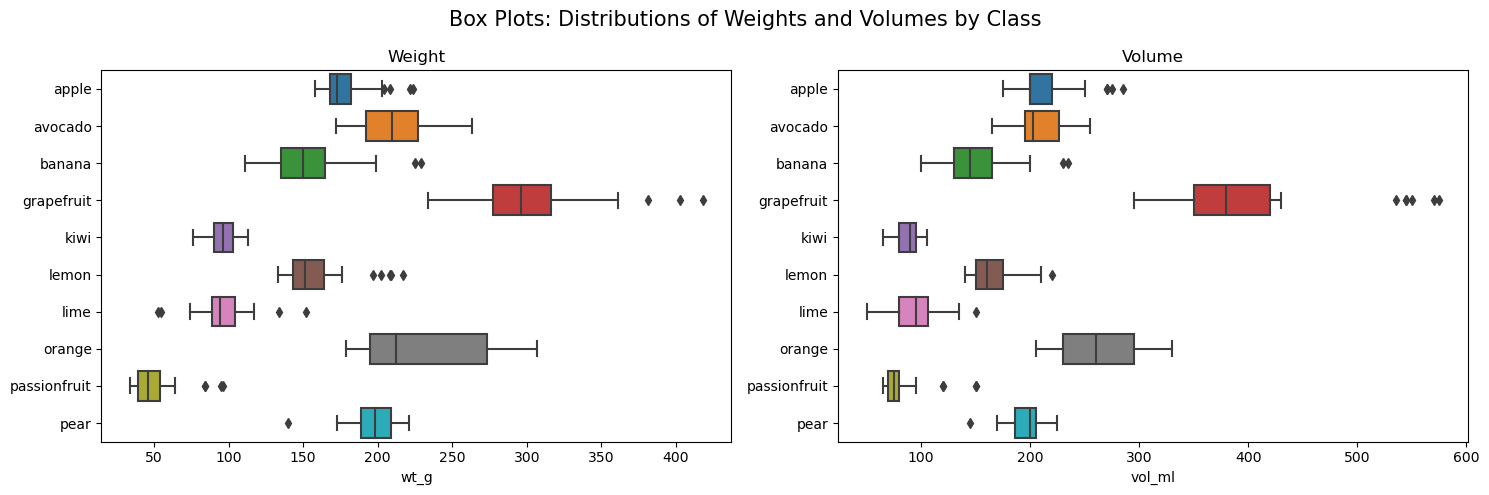

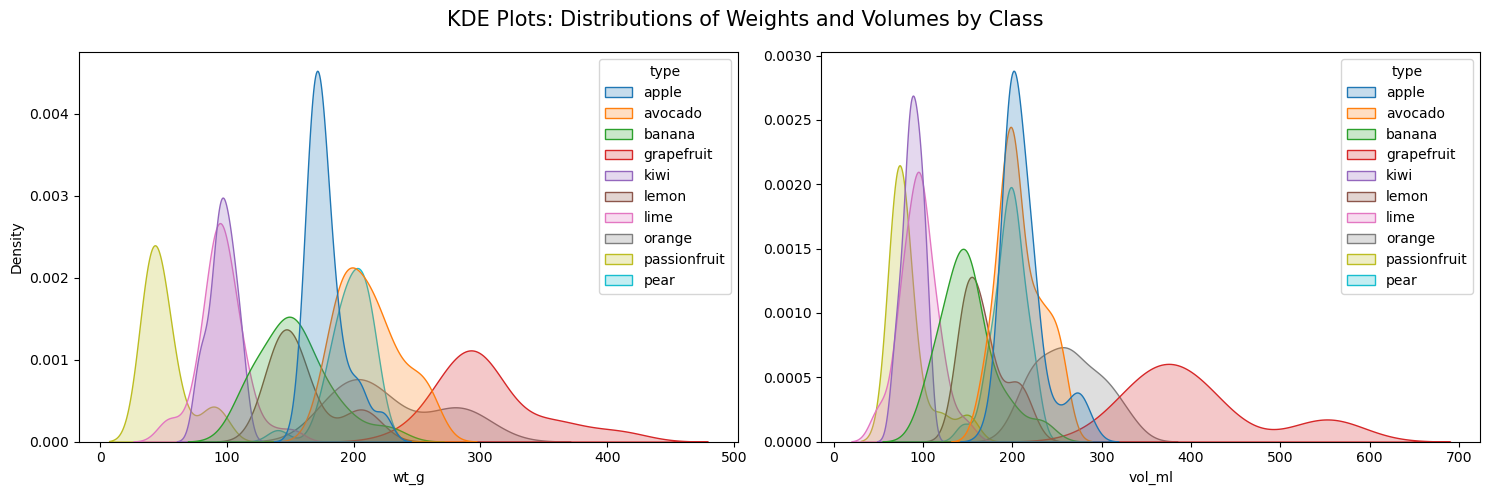

In [21]:
#weight and volume distributions
fig,ax = plt.subplots(1,2, figsize = (15,5))
titles = ['Weight','Volume']
for i,(var_i,ax_i) in enumerate(zip(extensive_vars,ax)):
    sns.boxplot(x = var_i, y = target, order = sorted_classes, data = train_data, ax = ax_i)
    ax_i.set_ylabel('')
    ax_i.set_title(titles[i])
fig.suptitle('Box Plots: Distributions of Weights and Volumes by Class', size = 15)
fig.tight_layout()
plt.show()

fig,ax = plt.subplots(1,2, figsize = (15,5))
for i,(var_i,ax_i) in enumerate(zip(extensive_vars,ax)):
    sns.kdeplot(x = var_i, hue = target, hue_order = sorted_classes, fill = 'true', data = train_data, ax = ax_i)
    if i==1:
        ax_i.set_ylabel('')
fig.suptitle('KDE Plots: Distributions of Weights and Volumes by Class', size = 15)
fig.tight_layout()
plt.show()

The below scatterplot shows that these variables are strongly correlated, as one would expect. However, we also see that the linear relationship is not uniform across all fruit types. For example, while apples and avocados overlap with respect to both weight and volume, the volume of an apple tends to be larger for an avocado of the same weight. The blue dots representing the apple tend to be elevated above the orange dots representing the avocados, and there is a diagonal boundary separating the two classes. This suggests that both weight and volume contain unique information relevant to accurately classifying them. 

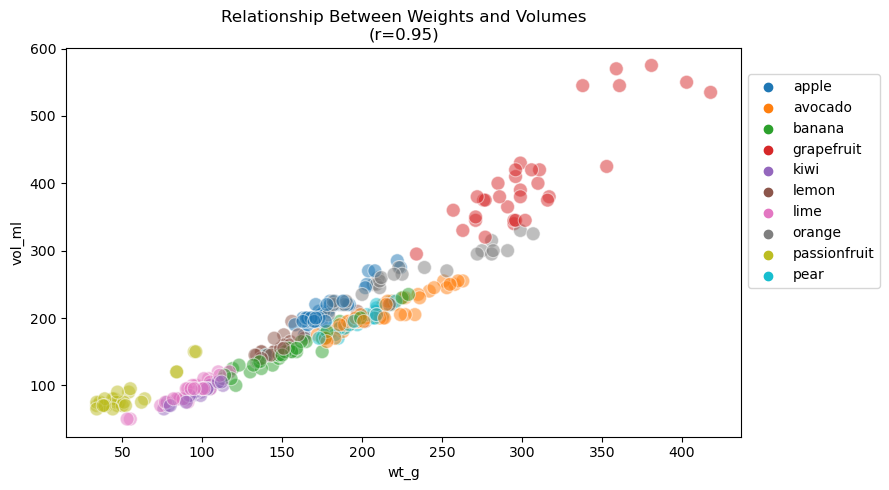

In [22]:
#relationship between weight and volume
r = round(stats.pearsonr(train_data['wt_g'], train_data['vol_ml'])[0], 2)
plt.figure(figsize = (9,5))
sns.scatterplot(x = 'wt_g', y = 'vol_ml', hue = target, hue_order = sorted_classes, s = 100, alpha = 0.5, data = train_data)
plt.title('Relationship Between Weights and Volumes\n(r={})'.format(r))
plt.legend(bbox_to_anchor = (1,0.95))
plt.tight_layout()
plt.show()


#### PCA for Data Rotation 

<a id='pca_tree'></a>
Whereas we will apply PCA to the image data as a means of <i>dimensionality reduction</i>, we may want to apply PCA to weight and volume variables and <i>keep all of their PCs</i>. This would effectively <i>rotate</i> these predictors using the new coordinate system that PCA generates. The reason we would do this is because of the <i>diagonal boundaries</i> that we observe, such as the one dividing apples and avocados. These diagonal boundaries can hinder tree-based classifiers because of the way that these classifiers build their boundaries, splitting on one variable at a time in an orthogonal fashion. A simple illustration of how tree classifiers can perform better when their predictors are rotated with PCA is shown [here](#pca_tree_ex). 

The below plot reveals how the weight and volume variables look after rotation via PCA. It looks like several of the classes that were previously divided along diagonal boundaries can now be split along horizontal and vertical boundaries. For example, the plot indicates that it is possible to completely separate apples and avocados with a single split on the second PC, whereas dividing these two classes would have required multiple successive splits using both weight and volume variables in the raw data. This example also shows that the second PC can be far more useful for splitting certain classes than the first, even if the first contains more variance, reinforcing the idea that the main benefit of PCA in this case is the rotation of the data that is achieved from keeping all of the PCs, rather than its potential to reduce the data by discarding the second PC and only keeping the first. 

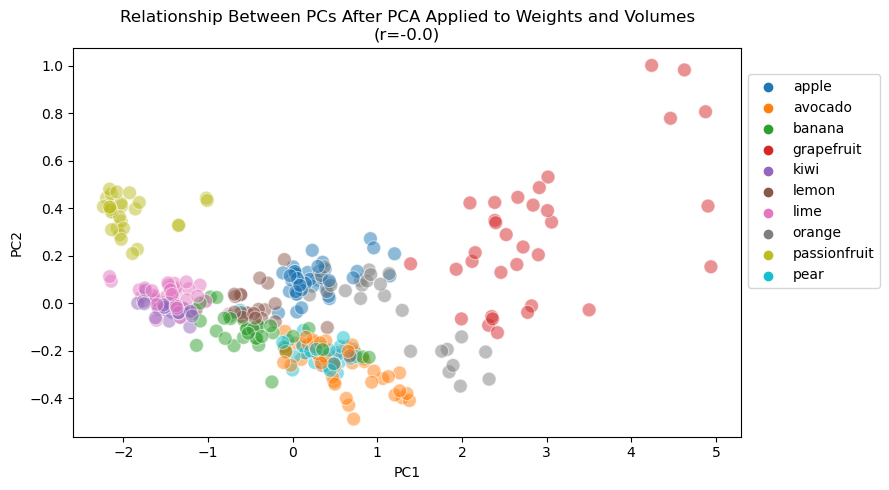

In [23]:
#apply PCA and visualize rotation
X_scaled = StandardScaler().fit_transform(train_data[extensive_vars])
X_pca = PCA(n_components = 2, svd_solver = 'full').fit_transform(X_scaled)
plot_data = pd.DataFrame(X_pca, columns = ['PC1', 'PC2'])
plot_data[target] = np.array(train_data[target])
#plot data
plt.figure(figsize = (9,5))
r = round(stats.pearsonr(plot_data['PC1'], plot_data['PC2'])[0], 2)
sns.scatterplot(x = 'PC1', y = 'PC2', hue = target, hue_order = sorted_classes,s = 100, alpha = 0.5, data = plot_data)
plt.title('Relationship Between PCs After PCA Applied to Weights and Volumes\n(r={})'.format(r))
plt.legend(bbox_to_anchor = (1,0.95))
plt.tight_layout()
plt.show()

As an aside, an important extension of the relationship between data rotation via PCA and tree classifiers is the rotation forest machine learning algorithm. Although it extends beyond the scope of this analysis, a reference to the original paper by Kuncheva and Rodríguez -- the inventors of this relatively new but highly promising method -- is provided in the PCA references section [here](#pca_ref).

### Implementing Data Transformations

Based on the all of this exploratory analysis, we will want to apply several transformations to our predictors. The below cell adds the three color mean variables computed above to the training and testing datasets. 

In [24]:
#add color stats to training data
color_means_data_train.index = train_data.index
train_df = pd.concat((train_data.loc[:,:'vol_ml'],
                                color_means_data_train.loc[:,'red_mean':],
                                train_data.loc[:,'r_0_0':],),axis = 1)
#add color stats to testing data
color_means_data_test = get_color_means_df(test_data,colors)
color_means_data_test.index = test_data.index
test_df = pd.concat((test_data.loc[:,:'vol_ml'],
                               color_means_data_test.loc[:,'red_mean':],
                               test_data.loc[:,'r_0_0':],),axis = 1)
#reset indices of train and test dfs
train_df = train_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

We will also want to do scaling and PCA. However, these transformations differ from calculating the color means in a fundamental way, which precludes us from conducting them in advance of our modeling with a one-off computation. 

The color mean values represent an independent calculation for each individual fruit, and the data used to compute one fruit's mean values will not be used in any way for computing any other fruit's mean values. Everything is done row-wise, with the mean values depending only on data from a single fruit's row. This means that whether a fruit is in the training set or the testing set, its mean color values will always be the same.

The same cannot be said for either scaling or PCA transformations. The values computed in both of these cases are based on all of the rows contained within a given dataset. This means we need to fit our scaling and PCA transformers to the training data, apply that transformation to the training set, and apply the same transformation <i>that was fit to the training data</i> to the testing set. This way, we ensure that the testing data's predictors are transformed based <i>only</i> on what is known about the training data, and that the training data is not transformed based on any information contained in the testing data. Otherwise, the models would indirectly gain information about the testing data while they are being trained. This is something known as <a href="https://en.wikipedia.org/wiki/Leakage_(machine_learning)">data leakage</a>, and would undercut the purpose of splitting the data into separate training and testing sets. We will need to use this approach not only for the train-test split, but also for each split when we apply cross-validation to tune hyperparameters (more on this below). 

For this reason, we will hold off on applying scaling and PCA to the data for now, and integrate it into the machine learning pipeline that we will specify later.

## Machine Learning

In this section, we will train machine learning models and evaluate them based on their ability to accurately classify "new" samples of fruit that the models did not encounter while they were being trained.

The three types of machine learning approaches evaluated here include KNN, decision tree, and random forest classifiers. Very brief conceptual explanations of each approach are given below, along with links to toy examples and references located at the end of the notebook. 

##### KNN
<a id='knn'></a>
The <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">KNN</a> classification algorithm assigns new data points of unknown classes to the <a href="https://en.wikipedia.org/wiki/Plurality_(voting)">plurality</a> class of the k points in the training set that are "nearest" to the new data point with respect to the predictors. The geometric distance between data points' predictor values is used to determine how near two neighbors are, and there are various distance metrics that can be used for this. Intuitively, geometric distance represents similarity, and the general idea is that new data points should be assigned to the class most commonly observed among their most similar points. 

Two important <a href="https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)">hyperparameters</a> -- or model specifications that are selected in advance of modeling rather than learned from the data -- include the function for calculating distances between points and the number of nearest neighbors used to classify new points (i.e., k). Generally, smaller k values can lead to noisier boundaries between classes that are sensitive to small number of training points and might therefore result in overfitting, while larger values result in smoother boundaries and may result in underfitting.

[KNN Toy Example](#knn_toy)<br>
[KNN References](#knn_ref)

##### Decision Tree
<a id='tree'></a>
A <a href="https://en.wikipedia.org/wiki/Decision_tree">decision tree</a> classification model successively splits the training data into partitions or "nodes," aiming to maximize the class "purity" of the nodes created with each split point. All of the data begins in a single "root node," and at each step the algorithm selects a specific value of a specific variables that best split the data into new classes with greater class purity. A "leaf node" is formed when a group consists only of a single class or some other stopping criteria is reached, and data points contained within the leaf are assigned to the plurality class that the leaf contains. New data points' predictor values determine the leaf node to which they belong and, by extension, the class to which they belong. 

Decision trees are often susceptible to becoming overfit to noise in the training data and failing to generalize well for new data if they grow too "deep" -- i.e., if the training data is split into too many leaf nodes. Therefore, there are various hyperparameters that can be used to impose limits on the number of nodes in the tree. Another notable hyperparameter is the metric for measuring the purity of nodes at each split, such as <a href="https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity">gini impurity</a> or <a href="https://en.wikipedia.org/wiki/Decision_tree_learning#Information_gain">entropy</a> criteria.

[Decision Tree Toy Example](#tree_ex)<br>
[Decision Tree References](#tree_ref)


##### Random Forest 
<a id='forest'></a>

<a href="https://en.wikipedia.org/wiki/Random_forest">Random forests</a> are an ensemble of many trees, which are all grown independently of each other. They generally have two sources of randomness -- each tree typically uses a random sample of the training data, as well as a random subset of predictors to consider for splitting the data. Predictions for new data are made based on the plurality class prediction among all of the trees in the forest. These two sources of randomness, coupled with the aggregated approach to prediction, help avoid the overfitting problem that individual trees frequently encounter, and tend to yield more accurate predictions on new data.

[Random Forest Toy Example](#forest_ex)<br>
[Random Forest References](#forest_ref)

### Examining Predictor Sets and Selecting Hyperparameters via Cross-Validation

Before building models on the full training set, we will first evaluate different sets of predictors and hyperparameters for each of the three machine learning approaches using cross-validation.

##### Predictor Sets

There is an extremely large number of potential predictor combinations in this case, and we will only examine a few subsets of the predictors. These are defined in the cell below, and include:

Image sets:
 - Set 1: All of the raw image data (i.e., all of the 28,224 RGB values).
 - Set 2: The three color means.
 - Set 3: The top 5 PCs from the image data. 
 - Set 4: The top 10 PCs from the image data. 
 - Set 5: The top 30 PCs from the image data.
 
Weight and volume sets:
 - Set 6: The weight and volume variables.
 - Set 7: Both PCs from the weight and volume variables.
 
Combination:
 - Set 8: A combination of the best performing set of predictors among sets 3-5 (i.e., the image PC sets) and the best performing set of predictors among sets 6 and 7 in terms of prediction accuracy. Note that this predictor set is not included in the below code cell, as it may be different for each model. It is therefore added dynamically later in the code.

In [25]:
#define initial predictor sets
predictor_sets = {'IMG_RAW':         {'preds':raw_img_vars,   'preds_pca':[],            'n_components':False},
                  'IMG_COLOR_MEANS': {'preds':color_mean_vars,'preds_pca':[],            'n_components':False},
                  'IMG_PCA05':       {'preds':raw_img_vars,   'preds_pca':raw_img_vars,  'n_components':5},
                  'IMG_PCA10':       {'preds':raw_img_vars,   'preds_pca':raw_img_vars,  'n_components':10},
                  'IMG_PCA30':       {'preds':raw_img_vars,   'preds_pca':raw_img_vars,  'n_components':30},
                  'WT_VOL_RAW':      {'preds':extensive_vars, 'preds_pca':[],            'n_components':False},
                  'WT_VOL_PCA02':    {'preds':extensive_vars, 'preds_pca':extensive_vars,'n_components':2}}

##### Hyperparameters

There are also many options for <a href="https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)">hyperparameters</a> to choose from, and those that will be evaluated are in the table below. 

For KNN, we will try every odd number between 1 and 29 for the k parameter, which indicates how many nearest neighbors to consider when predicting the class of the testing data. For the decision tree and random forest approaches, we will explore different min. samples leaf and min. impurity decrease values. Both of these are split-stopping criteria that are intended to keep trees from growing too deep and overfitting to the training data. Min. samples leaf represents the number or fraction of training data samples present in each node created by a split that will be required if a split is to take place. If the split would result in fewer than min. samples leaf in at least one of the nodes, it will not occur. Similarly, min. impurity decrease sets a minimum requirement on the reduction of class impurity in the child nodes relative to the node being split. The specific formula for calculating the reduction in impurity is in Scikit-Learn's <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">documentation</a>.

|Model Approach|Parameter|Values Examined|
|:---|:---|:---|
|KNN|K|{1, 3, 5, ..., 15}|
|Decision Tree|Min. Samples Leaf|{1, 0.005, 0.01, 0.025}|
|Decision Tree|Min. Impurity Decrease|{0.0, 0.005, 0.01, 0.025}|
|Random Forest|Min. Samples Leaf|{1, 0.005, 0.01, 0.025}|
|Random Forest|Min. Impurity Decrease|{0.0, 0.005, 0.01, 0.025}|

Note that the hyperparameter options explored here are limited. For most of the model hyperparameters not included in the above table, we will simply use the default values provided in the Scikit-Learn model classes. For example, for the KNN approach, we could try different distance metrics, but instead we will only use the default L2 distance function. An exception to this is the number of trees in the random forest model, which is set to 200 instead of the default 100. 

In [26]:
#knn
knn_hyperparams = {'model__n_neighbors': [i for i in range(1,15+1,2)]}

#decision tree
dt_hyperparams  = {'model__min_samples_leaf':     [1,    0.005,0.01,0.025],
                   'model__min_impurity_decrease':[0.0,  0.005,0.01,0.025]}

#random forest
rf_hyperparams  = {'model__min_samples_leaf':     [1,    0.005,0.01,0.025],
                   'model__min_impurity_decrease':[0.0,  0.005,0.01,0.025]} 

##### Cross-Validation Method

The method that we will use for evaluating how these various predictor sets and hyperparameters perform is <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)">cross-validation</a>. 

Cross-validation is a method for testing different modeling options across different randomized portions of the data. It allows us to train and test different model specifications using various train-test splits of the data and average their performance across these splits. This approach is more robust and less sensitive to random noise in the data than any single split between training and testing sets, thus giving us more confidence in our estimates of model performance on new data. 

There are many types of cross-validation, including leave-one-out cross-validation, Monte Carlo cross validation, and k-fold cross validation, which is the method used here. K-fold cross validation randomly partitions the data into k equally-sized partitions. It then iterates k times and at each iteration, it uses all of the folds except one are to train the model, and the remaining fold to test the model's predictive performance. Each fold is used to test the model's performance exactly once, and the performance is averaged across all of the iterations. Scikit-Learn provides a useful <a href="https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold">overview</a> of k-fold cross-validation with examples using its various built-in packages.

In this application, we will apply cross-validation to the training set, and use this to select candidate models from each of the three machine learning approaches based on mean classification accuracy across the folds. These three candidates will later be evaluated on the testing set. We will use seven folds, and they will be stratified, meaning that our random sampling method will result in roughly equal proportions of target classes across each of the folds. This cross-validation method is specified in the code cell below.

In [27]:
#specify cv method
cv = StratifiedKFold(n_splits = 7, shuffle = True, random_state = 0)

##### Using a Pipeline to Avoid Data Leakage

Previously, it was mentioned that we cannot perform certain transformations -- such as scaling and PCA -- on the entire training set at once because of the risks of data leakage. Instead, we need to perform these transformations at each iteration of cross validation, as well as when we evaluate the model on the hold-out testing set, with the transformation fitted only to the data used for training in each case. Scikit-Learn's <a href="https://scikit-learn.org/stable/modules/compose.html#pipeline">Pipeline</a> class provides a clean framework specifically designed for this purpose. 

The `build_pipeline( )` function defined in the below makes use of the Pipeline class, and can specify three alternative pipelines depending on the input values:

- <b>I.</b> If we want to apply PCA to the raw image variables for dimensionality reduction <i>and</i> to the weight and volume variables for rotation, `n_components` will be a two-tuple of scalar values and `preds_pca_idx` will be a two-tuple of lists of indices upon which to apply PCA. The number at `n_components[i]` represents the number of PCs to keep from the PCA transformation applied to the predictors represented in `preds_pca_idx[i]`. This pipeline entails the following steps:
  1. Scale predictors specified in `preds_pca_idx[0]` with StandardScaler.
  2. Apply PCA only to the predictors scaled in Step 1 and reduce them to `n_components[0]`.
  3. Scale predictors specified in `preds_pca_idx[1]` with StandardScaler.
  4. Apply PCA only to the predictors scaled in Step 3 and reduce them to `n_components[1]`.
  5. Scale all of the predictors to a range between -10 and +10 using Scikit Learn's <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">implementation</a> of min-max scaling. This second round of scaling is done to bring all of the predictors -- both those that underwent PCA transformation and those that did not -- to the <i>exact</i> same scale for the sake of the KNN approach. Decision trees and random forests are not sensitive to scale, so we assume this will not significantly undercut their performance. 
  6. Feed transformed predictors into the model.
  

- <b>II.</b> If we only want to apply PCA <i>only</i> to the raw image variables for dimensionality reduction, `n_components` will be a scalar value (or int) and `preds_pca_idx` will be a list of the predictor indices upon which to apply PCA (i.e., the indices of the raw image variables). The pipeline will entail the following steps:
  1. Scale only the predictors specified in `preds_pca_idx` with StandardScaler.
  2. Apply PCA only to the predictors in Step 1 and reduce them to `n_components`.
  3. Scale all predictors to a range between -10 and +10 with min-max scaling.
  4. Feed transformed predictors into the model.
 
 
- <b>III.</b> If we do not want to apply PCA to any predictors, `n_components` and `preds_pca_idx` will both be false, and the pipeline will entail the following steps:
  1. Scale all predictors to a range between -10 and +10 with min-max scaling.
  2. Feed transformed predictors into the model.

Note that alternatives 1 and 2 are accomplished via nested pipelines within column transformers, which allows us to apply successive transformations to subsets of the predictors. Any remaining predictors excluded from the column transformer are passed through untransformed, and their columns are appended to the right side of our new set of predictors.

In [28]:
def build_pipeline(model_obj, n_components = False, preds_pca_idx = []):
    """Function for building a pipeline
    Input
    ----------
    model_obj: sklearn estimator object
        The model that we will integrate into the pipeline
    n_components: int or tuple w/ length 2 of ints
        If int: The number of principal components we wish to use, if any
        If tuple: The number of principal components we wish to use for each subset of components
    preds_pca_idx: list or tuple w/ length 2 of lists
        If list: The list of column indices of predictors upon which we will apply PCA, if any
        If tuple: Tuple of lists of column indices of predictors upon which we will apply PCA, if any, for each 
        subset of predictors
        Default is an empty list (i.e., no PCA)
    Returns
    ----------
    pipeline: sklearn.pipeline.Pipeline object
        The pipeline that we will use to transform and model the data in 
        cross-validation and testing
    """
    #clone model
    model = clone(model_obj)
    
    #alternative I
    #if n_components is tuple
    if type(n_components)==tuple:
        #ensure parameters agree
        assert type(preds_pca_idx) == tuple, 'Error: If n_components is tuple, preds_pca_idx must also be tuple.'
        assert len(preds_pca_idx[0])==n_components[0], 'Error: All components should be kept for first subset of predictors upon which PCA will be applied.'
        assert len(n_components)==2, 'Error: If n_components is tuple, it must have length 2.'
        assert len(preds_pca_idx)==2, 'Error: If preds_pca_idx is tuple, it must have length 2.'
        #get n_components 1 and 2 
        n_components1 = n_components[0]
        n_components2 = n_components[1]
        #get predictor subset indices
        preds_pca_idx1 = preds_pca_idx[0]
        preds_pca_idx2 = preds_pca_idx[1]
        #specify transformations for each pca var group
        nested_pipe1 = Pipeline(steps = [('scaler', StandardScaler()),
                                         ('transformer', PCA(n_components = n_components1, svd_solver = 'full'))])
        nested_pipe2 = Pipeline(steps = [('scaler', StandardScaler()),
                                         ('transformer', PCA(n_components = n_components2, svd_solver = 'full'))])
        #specify pipeline steps
        pipeline_steps = [ ('columntransformer1', ColumnTransformer(
                              transformers = [('nested_pipe', nested_pipe1, preds_pca_idx1)],
                              remainder = 'passthrough')),
                           ('columntransformer2', ColumnTransformer(
                              transformers = [('nested_pipe', nested_pipe2, preds_pca_idx2)],
                              remainder = 'passthrough')),
                           ('scaler', MinMaxScaler(feature_range = (-10,10)) ),
                           ('model', model) ]
    #alternative II
    #if n_components is int...
    elif type(n_components)==int:
        #ensure parameters agree
        assert type(preds_pca_idx)==list,'Error: If n_components is an int, preds_trans_idx must be a list.'
        #specify transformation of pca var group
        nested_pipe = Pipeline(steps = [('scaler', StandardScaler()),
                                        ('transformer', PCA(n_components = n_components, svd_solver = 'full'))])
        #specify pipeline steps
        pipeline_steps = [ ('columntransformer1', ColumnTransformer(
                              transformers = [('nested_pipe', nested_pipe, preds_pca_idx)],
                              remainder = 'passthrough')),
                           ('scaler', MinMaxScaler(feature_range = (-10,10)) ),
                           ('model', model) ]
    #alternative III
    #if n_components is False, setup steps for only min-max scaling of all vars with no PCA
    elif n_components==False:
        #ensure parameters agree
        assert preds_pca_idx==[],'Error: If n_components is False, preds_pca_idx should be an empty list.'
        #specify pipeline steps
        pipeline_steps = [ ('scaler', MinMaxScaler(feature_range = (-10,10)) ),
                           ('model', model) ]
    
    #build pipeline using specified steps
    pipeline = Pipeline(steps = pipeline_steps)
    #return pipeline
    return pipeline


The below functions are additional helper functions. One thing worth noting is that the above pipeline is used in both the `get_cv_data( )` function and the `get_test_results( )` functions, so we are using identical pipelines for cross-validation and for final model testing to ensure continuity in terms of how the data is processed for both phases. In the former function, the pipeline feeds into Scikit-Learn's <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">GridSearchCV</a> class to accomplish the task of conducting cross-validation across all hyperparameters and producing cross-validation accuracy scores. In the latter, we use the pipeline directly to fit the models using the training data and then make predictions on the testing set.

In [29]:
#helper functions
def get_col_ids(df,col_names):
    """Function for getting numeric column indices from a dataframe based on column names
    Input
    ----------
    df: pd.DataFrame
        The data frame from which we want to derive column IDs
    col_names: list
        The list of column names for which we want numeric IDs
    Returns
    ----------
    col_idx: list
        A list of zero-indexed column IDs that 
        correspond to the provided column names.
    """
    col_idx = [df.columns.get_loc(i) for i in col_names]
    return col_idx

def get_cv_data(X,y,preds,preds_pca,n_components,model_obj,hyperparams):
    """Function for getting cross-validation results over a set of hyperparameters 
    using sklearn.GridsearchCV
    Input
    ----------
    X: pandas.DataFrame
        A dataframe containing all of the predictor data for the training set
    y: pandas.DataFrame
        A dataframe containing all of the target data for the training set
    preds: list
        A list containing column names of all predictors
    preds_pca: list or tuple w/ length 2 of lists
        If list: The list of column names of predictors upon which we will apply PCA, if any
        If tuple: Tuple of lists of column indices of predictors upon which we will apply PCA, if any, for each 
        subset of predictors
    n_components: int or tuple w/ length 2 of ints
        If int: The number of principal components we wish to use, if any
        If tuple: The number of principal components we wish to use for each subset of components
    model_obj: sklearn estimator object
        Specifies the modeling framework that will be examined in cross-validation 
        (e.g., sklearn.tree.DecisionTreeClassifier)
    hyperparams: dict
        A dictionary of model hyperparameters
        Dictionary keys are names of hyperparameters, and dictionary values are hyperparameter values
    Returns
    ----------
    cv_data: pandas.DataFrame object
        A dataframe of the cross-validation results
    """
    #copy predictors and target
    X_cv = X.copy()
    y_cv = y.copy()
    #clone model
    model_clone = clone(model_obj)
    #get ids for all relevant predictor columns
    preds_idx = get_col_ids(X_cv,preds)
    if type(preds_pca) == tuple:
        preds_pca_idx = tuple([get_col_ids(X_cv,i) for i in preds_pca])
    else:
        preds_pca_idx = get_col_ids(X_cv,preds_pca)
    #instantiate pipeline
    pipeline = build_pipeline(model_clone,n_components,preds_pca_idx)
    #instantiate grid
    grid = GridSearchCV(pipeline,param_grid = hyperparams,cv = cv,n_jobs = -1,scoring = 'accuracy')
    #run data through grid search cv
    grid.fit(X_cv,y_cv)
    #store cross-validation results in df
    cv_data = pd.DataFrame(grid.cv_results_)
    #return results 
    return {'cv_data':cv_data,'best_estimator':grid.best_estimator_}

def get_cv_data_all_predictor_sets(df,model_obj,predictor_sets,hyperparams):
    """Function for getting the cross-validation results for all of the predictor sets.
    by calling the get_cv_data() function for all predictor sets, plus the results for 
    the set of predictors that combines the best performing set of PCA predictors with
    the weight and volume predictors
    
    Input
    ----------
    df: pandas.DataFrame
        The full dataset that will be used for cross-validation 
        (i.e., everything but the hold-out testing dataset)
    model_obj: sklearn estimator object
        Specifies the modeling framework that will be examined in cross-validation 
        (e.g., sklearn.tree.DecisionTreeClassifier)
    predictor_sets: dict
        A dictionary of predictor sets
        Each key is the name of the predictor set and each value is a nested dictionary
        Each nested dictionary contains three keys:
            'preds': values is a list of all predictor names
            'preds_pca': value is a list of all names, if any, of predictors upon which PCA will be applied
            'n_components': value is the number of principal components that will be used if PCA is applied
    hyperparams: dict
        A dictionary of model hyperparameters
        Dictionary keys are names of hyperparameters, and dictionary values are hyperparameter values
    Returns
    ----------
    cv_results_all_predictor_sets: dict
        A dictionary containing the results of cross-validation across the predictor sets
    """
    #copy df
    data = df.copy()
    #create dict to store datasets
    cv_results_datasets = {}
    #create dict to store best estimators
    best_estimators = {}
    #iterate through predictor sets
    for key,val in predictor_sets.items():  
        #instantiate model
        model_clone = clone(model_obj)
        #define variables
        preds = val['preds']
        preds_pca = val['preds_pca']
        n_components = val['n_components']  
        #partition X and y
        X = data[preds].copy()
        y = data[target].copy()
        #get cv data
        cv_data = get_cv_data(X,y,preds,preds_pca,n_components,model_clone,hyperparams)
        #store cv data with predictor set
        cv_results_datasets[key] = cv_data['cv_data'].copy()
        #store best estimator
        best_estimators[key] = cv_data['best_estimator']

    #################################################################
    #add new predictor set and apply CV to it based on above results
    #################################################################
    #get best n components for PCA
    pca_img_scores = [(val['mean_test_score'].max(),key) for key,val in cv_results_datasets.items() if 'IMG_PCA' in key]
    pca_img_scores_sorted = sorted(pca_img_scores, reverse = True)
    pca_img_best = pca_img_scores_sorted[0][1]
    pca_img_best_n_components = predictor_sets[pca_img_best]['n_components']
    #determine whether WT_VOL vars did better with or without PCA
    wtvol_scores = [(val['mean_test_score'].max(),key) for key,val in cv_results_datasets.items() if 'WT_VOL_' in key]
    wtvol_scores_sorted = sorted(wtvol_scores, reverse = True)
    wtvol_best = wtvol_scores_sorted[0][1]
    #specify new combination predictor set based on original predictor set performances
    new_preds = extensive_vars+raw_img_vars
    if 'PCA' in wtvol_best:
        new_preds_pca = (extensive_vars,raw_img_vars)
        new_n_components = (2,pca_img_best_n_components)
    else:
        new_preds_pca = raw_img_vars
        new_n_components = pca_img_best_n_components
    #define new predictor set
    new_predictor_set = {'preds': new_preds, 'preds_pca': new_preds_pca, 'n_components': new_n_components}
    new_predictor_set_name = 'BEST COMBO: {} AND {}'.format(wtvol_best, pca_img_best)
    #instantiate model
    model_clone = clone(model_obj)
    #define variables
    preds = new_predictor_set['preds']
    preds_pca = new_predictor_set['preds_pca']
    n_components = new_predictor_set['n_components']
    #partition X and y
    X = data[preds].copy()
    y = data[target].copy()
    #get cv data
    cv_data = get_cv_data(X,y,preds,preds_pca,n_components,model_clone,hyperparams)
    #add cv data to model results datasets dictionary
    cv_results_datasets[new_predictor_set_name] = cv_data['cv_data'].copy()
    #store best estimator
    best_estimators[new_predictor_set_name] = cv_data['best_estimator']
    #return model results dictionary
    cv_results_all_predictor_sets = {'cv_results_datasets': cv_results_datasets,
                                     'best_estimators':best_estimators,
                                     'pca_img_best_n_components':pca_img_best_n_components,
                                     'pca_img_best':pca_img_best,
                                     'wtvol_best':wtvol_best}
    return cv_results_all_predictor_sets 

def get_cv_plot_data(cv_results, model_type):
    """Function for getting cross-validation data that can be used for plotting.
    Input
    ----------
    cv_results: dict
        Output from get_cv_data_all_predictor_sets
    model_type: string
        String describing the model type
        Must be in {'knn','tree','forest'}
    Returns
    ----------
    cv_plot_df: pandas.DataFrame
        A dataframe that can be used for plotting cross-validation results
        when plugged into the function get_model_results_plot
    """  
    #extract best n_components for PCA
    pca_img_sets = [i for i in cv_results['cv_results_datasets'].keys() if i.startswith('IMG_PCA')] 
    pca_img_best_n_components = cv_results['pca_img_best_n_components']
    cv_results_datasets = cv_results['cv_results_datasets']
    #create df to contain cv plot data for all predictor sets
    cv_plot_df = pd.DataFrame()
    #iterate through cv results datasets (recall each key is predictor set, each val is cv results df)
    for key,val in cv_results_datasets.items():
        #only include img pca data that achieved best results among other img pca data
        if key in pca_img_sets:
            if int(''.join([j for j in key if j.isnumeric()])) != pca_img_best_n_components:
                continue
        #create copy of df, which already contains most of the useful info
        val = val.copy()
        #set hyperparameter values for different model types
        if model_type == 'knn':
            all_kvals = cv_results_datasets['IMG_RAW']['params'].apply(lambda x: x['model__n_neighbors'])
            val['K'] = all_kvals
        elif (model_type == 'tree') or (model_type == 'forest'):
            all_minsamplesleaf_vals = cv_results_datasets['IMG_RAW']['params'].apply(lambda x: x['model__min_samples_leaf'])
            val['min_samples_leaf'] = all_minsamplesleaf_vals
            all_minimpuritydecrease_vals = cv_results_datasets['IMG_RAW']['params'].apply(lambda x: x['model__min_impurity_decrease'])
            val['min_impurity_decrease'] = all_minimpuritydecrease_vals
        #add predictor set col
        val['predictor_set'] = [key] * val.shape[0]
        #plot x axis values (just a range)
        val['x'] = [i for i in range(val.shape[0])]
        #+/-standard deviation vals
        val['plus_std'] = val['mean_test_score'] + (val['std_test_score'])
        val['minus_std'] = val['mean_test_score'] - (val['std_test_score'])
        #concatenate data fromm predictor set onto full dataset for all predictor sets
        cv_plot_df = pd.concat((cv_plot_df,val))     
    return cv_plot_df

def get_model_results_plot_bokeh(cv_plot_data, model_type, sd_fill = False):
    """Function for getting an interactive Bokeh figure to show 
    the cross-validation results of a given modeling approach 
    for various hyperparameters.
    Input
    ----------
    cv_plot_data: pd.DataFrame
        Dataframe containing cross-validation results
    model_type: string
        String describing the model type
        Must be in {'knn','tree','forest'}
    sd_fill: bool
        Indicates whether to fill the span between +/- 1 standard deviation
        centered on the mean in the cross-validation accuracy distributions
    Returns
    ----------
    f: A Bokeh figure object
        The figure on which the data will be plotted.
    """
    plot_colors = [(10,80,160), (70,150,200), (160,200,230),
                   (200,30,20), (250,100,70),
                   'black']      
    f = figure(y_range = (0.4,1.0))
    f.add_layout(Legend(), 'left')
    if model_type == 'knn':
        f.title = 'K-Nearest Neighbors'
        hover_tool = HoverTool(tooltips = [('K = ', '@K'), ('Mean CV Accuracy','@mean_test_score')])
    elif (model_type == 'tree') or (model_type == 'forest'):
        hover_tool = HoverTool(tooltips = [('Min Samples Leaf = ', '@min_samples_leaf'),
                                           ('Min Impurity Decrease = ', '@min_impurity_decrease'),
                                           ('Mean CV Accuracy','@mean_test_score')])
        if (model_type == 'tree'):    
            f.title = 'Decision Tree'
        elif (model_type == 'forest'):
            f.title = 'Random Forest'
    for i, set_i in enumerate(cv_plot_data['predictor_set'].unique()):
        subset_df = cv_plot_data[cv_plot_data['predictor_set']==set_i] 
        cds = ColumnDataSource(subset_df)
        f.line(x = 'x', y = 'mean_test_score', legend_label = set_i, color = plot_colors[i], line_width = 3, source = cds)
        f.circle(x = 'x', y = 'mean_test_score', color = plot_colors[i], legend_label = set_i, size = 5, source = cds)
        if sd_fill:
            f.varea(x = 'x', y1 = 'plus_std', y2 = 'minus_std', color = plot_colors[i], legend_label = set_i, alpha = 0.075, source = cds)
    f.add_tools(hover_tool)
    f.legend.title = 'Predictor Set (Click to Show/Hide)'
    if sd_fill:
        f.yaxis.axis_label = 'Cross Validation Accuracy (+/- 1 SD)'
    else:
        f.yaxis.axis_label = 'Cross Validation Accuracy'
    f.xaxis.axis_label = 'Hyperparameter Search'
    f.xaxis.major_label_text_font_size = '0pt'
    f.xaxis.major_tick_line_color, f.xaxis.minor_tick_line_color = None, None
    f.width, f.height = 900, 400
    f.toolbar.logo = None
    f.legend.click_policy = 'hide'
    return f

def plot_model_results_nobokeh(cv_plot_data, model_type, ax):
    """Function for getting an interactive Bokeh figure to show 
    the cross-validation results of a given modeling approach 
    for various hyperparameters.
    Input
    ----------
    cv_plot_data: pd.DataFrame
        Dataframe containing cross-validation results
    model_type: string
        String describing the model type
        Must be in {'knn','tree','forest'}
    ax: matplotlib.axes object
        Subplot on which to plot the data
    Returns
    ----------
    f: None 
        Visualization only
    """
    linewidth   = 3
    legendsize  = 10
    plot_colors = [(10/255,80/255,160/255,1), (70/255,150/255,200/255,1), (160/255,200/255,230/255,1),
                   (200/255,30/255,20/255,1), (250/255,100/255,70/255,1),
                   'black']  
    if model_type == 'knn':
        ax.set_title('K-Nearest Neighbors')
        param_names = ['K']
        opt_param_vals = []

    elif (model_type == 'tree') or (model_type == 'forest'):
        param_names = ['Min Samples Leaf','Min Impurity Decrease']
        opt_param_vals = []
        if (model_type == 'tree'):    
            ax.set_title('Decision Tree')
        elif (model_type == 'forest'):
            ax.set_title('Random Forest')
    
    max_scores = []
    for i, set_i in enumerate(cv_plot_data['predictor_set'].unique()):
        subset_df = cv_plot_data[cv_plot_data['predictor_set']==set_i] 
        if re.match('BEST COMBO:', set_i):
            label = set_i.replace(': ', ':\n')
        else:
            label = set_i
        mx_idx = np.argmax(subset_df['mean_test_score'])
        mx_score = subset_df['mean_test_score'][mx_idx]
        opt_param_set = subset_df['params'][mx_idx]
        max_scores.append((mx_score,mx_idx,opt_param_set))
        ax.plot(subset_df['mean_test_score'].to_list(), marker = 'o',
                label = label, color = plot_colors[i], linewidth = linewidth)
    #mark best score w/ params
    max_score, max_score_idx, opt_param_set = sorted(max_scores, reverse = True)[0]
    if model_type == 'knn':
        label_string = 'Best Score: {}%\n(K={})'.format(round(max_score*100,1),
                                                                    opt_param_set['model__n_neighbors'])
    else:
        label_string = 'Best Score: {}%\n(Min Impurity Decrease={}, Min Samples Leaf={})'\
                                                                    .format(round(max_score*100,1),
                                                                    opt_param_set['model__min_impurity_decrease'],
                                                                    opt_param_set['model__min_samples_leaf'])
    ax.text(x = max_score_idx, y = max_score+0.03, s = label_string, va = 'bottom', ha = 'left', size = 9)
    ax.scatter([max_score_idx], [max_score], marker = 'o', color = 'gray', s = 400, alpha = 0.3)
    ax.legend(title = 'Predictor Set', bbox_to_anchor = (1,1.026), prop = {'size': legendsize})
    ax.set_ylabel('Cross Validation Accuracy')
    ax.set_ylim(0.5,1.07)
    yticks = ax.get_yticks()
    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(yticks))
    ax.set_yticklabels(['{}%'.format(round(i*100)) for i in yticks])
    ax.set_xlabel('Hyperparameter Search')
    ax.set_xticks([])

def plot_best_cv_dists(cv_results_datasets, model_names, colors):
    """Function for plotting the distribution of the best cross-validation
     results for a given modeling approach and predictor set using a KDE plot.
    Input
    ----------
    cv_results_datasets: list
        List containing the cross-validation results
        of best-performing predictor set for a given modeling approach 
    model_names: list of strings
        The names of the models to show in the plot legend
    colors: list of strings
        The color names specifying the color of each model's distribution
    Returns
    ----------
    None
        (Visualization only)
    """
    best_scores = {}
    fig, (ax1,ax2) = plt.subplots(2,1,figsize = (12,6), sharex = True, height_ratios = [3,1])
    for i,(df,m,c) in enumerate(zip(cv_results_datasets,model_names,colors)):
        #extract plot data
        cols = df.columns
        split_score_cols = [i for i in cols if re.match('split[0-9]+_test_score',i)]
        best_split_scores = df[df['rank_test_score']==1][split_score_cols].iloc[0].values
        best_mean_split_score = df[df['rank_test_score']==1]['mean_test_score'].iloc[0]
        best_std_split_score = df[df['rank_test_score']==1]['std_test_score'].iloc[0]
        param_cols = [i for i in df.columns if re.match('param_model__*',i)]
        param_names = [i.replace('param_model__','') for i in param_cols]
        best_param_vals = df[df['rank_test_score']==1].iloc[0][param_cols].values
        param_string = '({})'.format(', '.join(['{}={}'.format(n,v) for n,v in zip(param_names,best_param_vals)]))
        #store best_scores
        best_scores[m] = best_split_scores
        #plot kdes 
        kde = sns.kdeplot(best_split_scores, color = c, alpha = 0, clip = (0,1), ax = ax1)
        x_vals, y_vals = kde.get_lines()[i].get_data()
        #means
        mean_idx = np.argmin(np.abs(best_mean_split_score-x_vals))
        mean_x, mean_y = x_vals[mean_idx], y_vals[mean_idx]
        ax1.vlines(x = mean_x, ymin = 0, ymax = mean_y, linestyle = '--', color = c)
        ax1.text(x = mean_x, y = mean_y, 
                 s = 'µ={}\n(σ={})'.format(round(best_mean_split_score,2),round(best_std_split_score,3)), 
                 ha = 'right', va = 'bottom',
                 size = 12)  
        sns.kdeplot(best_split_scores, color = c, fill = True, alpha = 0.3, clip = (0,1),
                    label = m + '\n' + param_string, ax = ax1)
    ax1.legend(loc = 'upper left')
    ax1.set_title("Cross-Validation Accuracy Distributions: Each Modeling Approach's Best Case")
    #plot violin/swarmplot
    violin_df = pd.melt(pd.DataFrame(best_scores))
    sns.violinplot(x = 'value', y = 'variable', inner = None, palette = colors, cut = 0.1,
                   data = violin_df, ax = ax2)
    plt.setp(ax2.collections, alpha = 0.6)
    sns.swarmplot(x = 'value', y = 'variable', alpha = 0.8, color = 'black', 
                   data = violin_df, ax = ax2)
    ax2.set_ylabel('') 
    ax2.set_xlabel('Accuracy')
    fig.tight_layout()
    plt.subplots_adjust(hspace = 0.04)
    plt.show()

def get_test_results(train_df, test_df, preds, preds_pca, n_components, model_obj):
    """Function for getting the results of a model's performance on the testing set.
    Input
    ----------
    train_df: pandas.DataFrame
        A dataframe containing the full training set
    test_df: pandas.DataFrame
        A dataframe containing the full testing set
    preds: list
        A list containing column names of all predictors
    n_components: int or tuple w/ length 2 of ints
        If int: The number of principal components we wish to use, if any
        If tuple: The number of principal components we wish to use for each subset of components
    preds_pca: list or tuple w/ length 2 of lists
        If list: The list of column names of predictors upon which we will apply PCA, if any
        If tuple: Tuple of lists of column indices of predictors upon which we will apply PCA, if any, for each 
        subset of predictors
    model_obj: sklearn estimator object
        Specifies the modeling framework that will be tested, with hyperparameters already specified 
        (e.g., sklearn.neighbors.KNeighborsClassifier(n_neighbors = 1))
    n_components: int
        The number of predictors derived from PCA dimensionality reduction
    Returns
    ----------
    test_results: dict
        A dictionary containing:
            testing_accuracy: The proportion of accurately classified observations
            y_pred: The predicted target values
            y_test: The true target values
            final_model: The final fitted model object
    """
    #partition X and y
    X_train = train_df[preds].copy()
    y_train = train_df[target].copy()
    X_test = test_df[preds].copy()
    y_test = test_df[target].copy()
    #clone model
    model_clone = clone(model_obj)
    #get ids for all relevant predictor columns
    preds_idx = get_col_ids(X_train,preds)
    if type(preds_pca) == tuple:
        preds_pca_idx = tuple([get_col_ids(X_train,i) for i in preds_pca])
    else:
        preds_pca_idx = get_col_ids(X_train,preds_pca)
    #instantiate pipeline
    pipeline = build_pipeline(model_clone, n_components, preds_pca_idx)
    #fit to training data
    pipeline.fit(X_train, y_train)
    #store the fitted model
    final_model = pipeline.named_steps['model']
    #predict for test set
    y_pred = pipeline.predict(X_test)
    #overall classification accuracy
    model_accuracy = np.mean(y_test == y_pred)
    #store test results in dictionary
    test_results = {'test_accuracy':model_accuracy,
                    'y_pred':y_pred,
                    'y_test':y_test,
                    'final_model':final_model}
    #return results
    return test_results

def plot_confusion_matrix(y_test, y_pred, model_type, ax, ylabel):
    """Function for plotting confusion matrix based on model's performance
    on the testing set
    Input
    ----------
    y_yest: np.array
        Target values from testing set.
    y_pred: np.array
        A model's predicted values for the testing set.
    model_type:
        A string describing the model type to be used in the plot title.
    ax: Matplotlib axes object
        Axes subplot on which to plot the confusion matrix
    ylabel: bool
        Boolean indicating whether to include a y axis label on the plot
    Returns
    ----------
    None
        (Visualization only)
    """
    test_acc = np.mean(y_pred==y_test)
    labels = sorted(set(y_test).union(set(y_pred)))
    cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels = labels, cmap = 'Blues',
                                           normalize = None, xticks_rotation = 90, values_format = '.2g',
                                           ax = ax, colorbar = False)
    ax.set_title('{}\nTesting Accuracy: {}'.format(model_type,test_acc))
    if not ylabel:
        ax.set_ylabel('')

The below code cell calls upon helper functions defined above to apply cross-validation for all of modeling approaches, with all of the predictor sets, and all of the hyperparameters discussed above. The results of cross-validation are stored in datasets for each model. Note that this code cell takes a long time to run. 

In [30]:
#knn
model_obj = KNeighborsClassifier()
knn_cv_results = get_cv_data_all_predictor_sets(train_df, model_obj, predictor_sets, knn_hyperparams)
knn_plot_data = get_cv_plot_data(cv_results = knn_cv_results, model_type = 'knn')
#decision tree
model_obj = DecisionTreeClassifier(random_state = 0)
dt_cv_results = get_cv_data_all_predictor_sets(train_df, model_obj, predictor_sets, dt_hyperparams)
dt_plot_data = get_cv_plot_data(cv_results = dt_cv_results, model_type = 'tree')
#random forest
model_obj = RandomForestClassifier(random_state = 0, n_estimators = 200)
rf_cv_results = get_cv_data_all_predictor_sets(train_df, model_obj, predictor_sets, rf_hyperparams)
rf_plot_data = get_cv_plot_data(cv_results = rf_cv_results, model_type = 'forest')

The next code cell produces visualizations of the cross-validation results. Setting `use_bokeh` to True will produce visualizations created with <a href="https://bokeh.org/">Bokeh</a> that have some interactive features. Because the Bokeh visualizations do not appear in the GitHub environment, setting `use_bokeh` to False will generate similar visuals using Matplotlib.

Note that among the predictor sets with image data reduced via PCA, only those associated with the number of PCs that achieved the best maximum accuracy across the hyperparameters are shown for each of the three machine learning methods. The number of PCs that performed best is shown in the plot legends. 

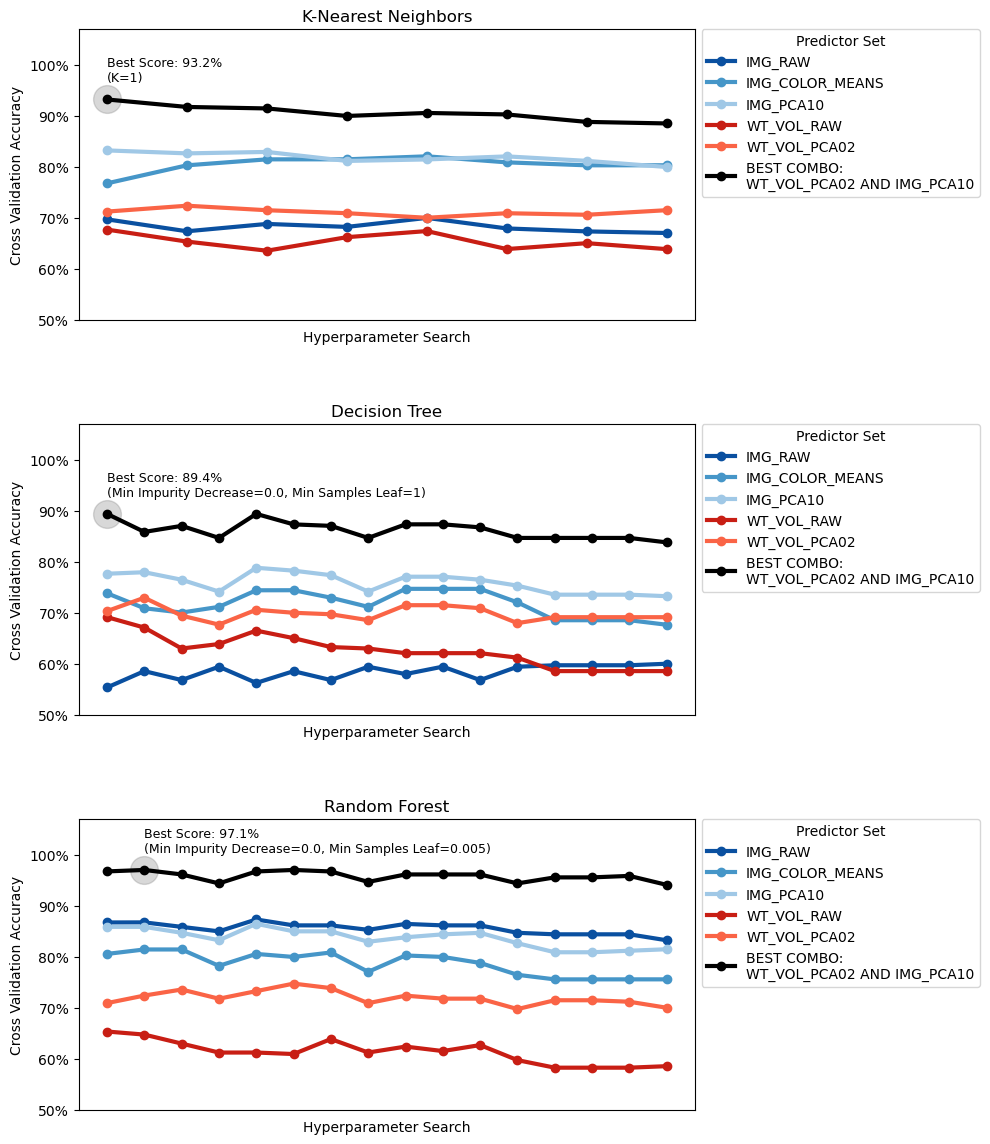

In [31]:
#plot cv results

#specify whether to use bokeh
use_bokeh = False
if use_bokeh:
    output_notebook()
    knn_fig = get_model_results_plot_bokeh(knn_plot_data, model_type = 'knn',    sd_fill = False)
    dt_fig  = get_model_results_plot_bokeh(dt_plot_data,  model_type = 'tree',   sd_fill = False)
    rf_fig  = get_model_results_plot_bokeh(rf_plot_data,  model_type = 'forest', sd_fill = False)
    show(column(knn_fig, dt_fig, rf_fig))
else:
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,12))
    plot_model_results_nobokeh(knn_plot_data, model_type = 'knn',    ax = ax1)
    plot_model_results_nobokeh(dt_plot_data,  model_type = 'tree',   ax = ax2)
    plot_model_results_nobokeh(rf_plot_data,  model_type = 'forest', ax = ax3)
    fig.subplots_adjust(hspace = 3)
    fig.tight_layout()

A couple of high-level takeaways from these visualizations:
- <b>Model Performance:</b> The random forest approach achieved the best overall performance, with 97.1 percent mean cross-validation accuracy, when min. samples leaf=0.005 and min. impurity decrease=0, and when using PCA-rotated weight and volume predictors in combination with 10 PCA variables reduced from the raw image predictors. KNN also performed reasonably well, with about 93 percent accuracy using the same set of predictors when k=1. In contrast, the decision tree did not generally perform well, never surpassing 90 percent accuracy with any predictor or hyperparameter set.
- <b>Predictor Sets:</b> Reducing the image data yielded significantly better results than using the raw image data for the KNN and decision tree methods, and the PCA-reduced variables achieved higher maximum accuracy scores than the color means variables. In contrast, the random forest proved more robust to the high-dimensionality of the raw image data, with these variables outperforming PCA and the color means. For the weight and volume variables, the PCA-rotation achieved better results than the original variables not only for the decision tree and random forest, as suspected, but for KNN as well. Overall, the combination of the best performing PCA-reduced image variable set and the best performing weight and volume set achieved the best accuracy across all machine learning approaches, at least out of the predictor sets examined here.

The above plots show <a href="https://en.wikipedia.org/wiki/Point_estimation">point estimates</a> of performance, but it is also useful to look at the distribution of accuracy scores across the various folds to get a sense of how consistent they were, and how much overlap there is between the accuracy distributions of the models.

The below code cell calls on a helper function to visualize these distributions for each of the three modeling approaches' best combinations of predictors and hyperparameters. The top visualization uses KDE plots to show the smoothed estimated distributions, and the empirical distributions are represented below using a swarm plot nested inside a violin plot. This shows that the random forest approach not only did best on average, but its accuracy scores across the various folds tended to be more consistent that than KNN and the decision tree, as demonstrated by its lower standard deviation and the clustering of points in the swarm plot at the higher end of its distribution. It was also the only one that never scores below 90 percent accuracy across any of the folds.

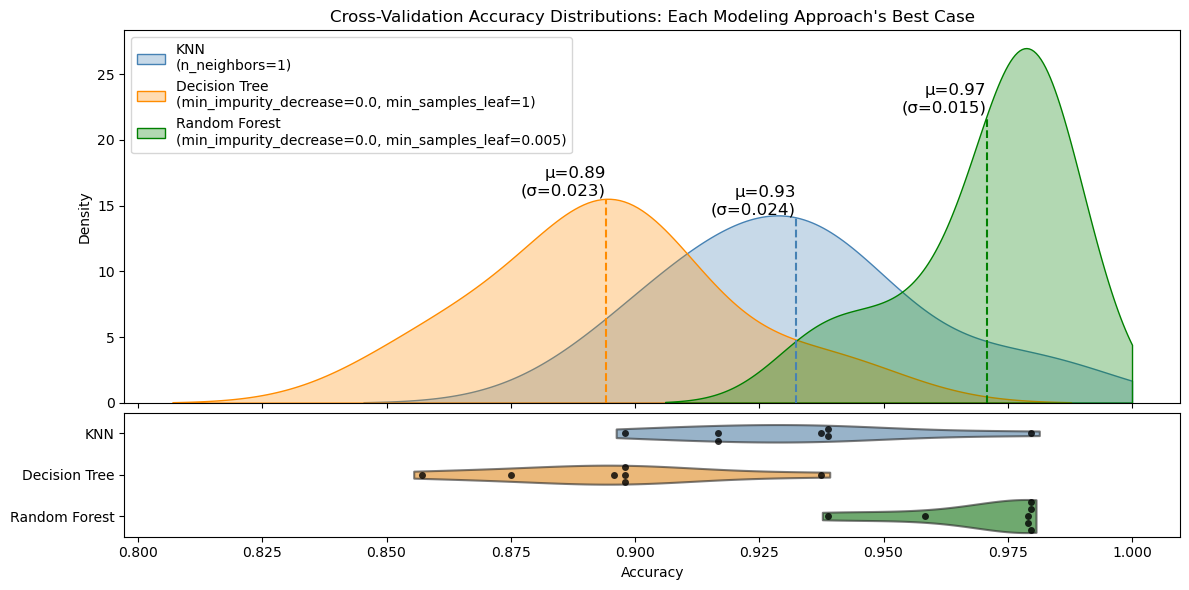

In [32]:
#plot distribution (kde) of mean cv accuracy scores for each model with best predictor set and best hyperparameters
knn_cv_data_best = knn_cv_results['cv_results_datasets']['BEST COMBO: WT_VOL_PCA02 AND IMG_PCA10'].copy()
dt_cv_data_best  = dt_cv_results['cv_results_datasets']['BEST COMBO: WT_VOL_PCA02 AND IMG_PCA10'].copy()
rf_cv_data_best  = rf_cv_results['cv_results_datasets']['BEST COMBO: WT_VOL_PCA02 AND IMG_PCA10'].copy()
plot_best_cv_dists(cv_results_datasets = [knn_cv_data_best,dt_cv_data_best,rf_cv_data_best], 
                   model_names = ['KNN','Decision Tree','Random Forest'], 
                   colors = ['steelblue','darkorange','green'])

Based on these cross-validation results, the random forest model appears to be the strongest candidate, followed by KNN then the decision tree. Next, we will see how these models performed on the hold-out testing set.

## Model Evaluation on the Testing Set

The below cell re-trains all of the three candidate models on the full training set, has each of them make predictions for the testing set, and calculates their testing accuracies. It also calls the `plot_confusion_matrix()` helper function defined above to generate confusion matrices for each model to show which types of fruits tended to be misclassified the most, and the fruit classes to which they were erroneously assigned.

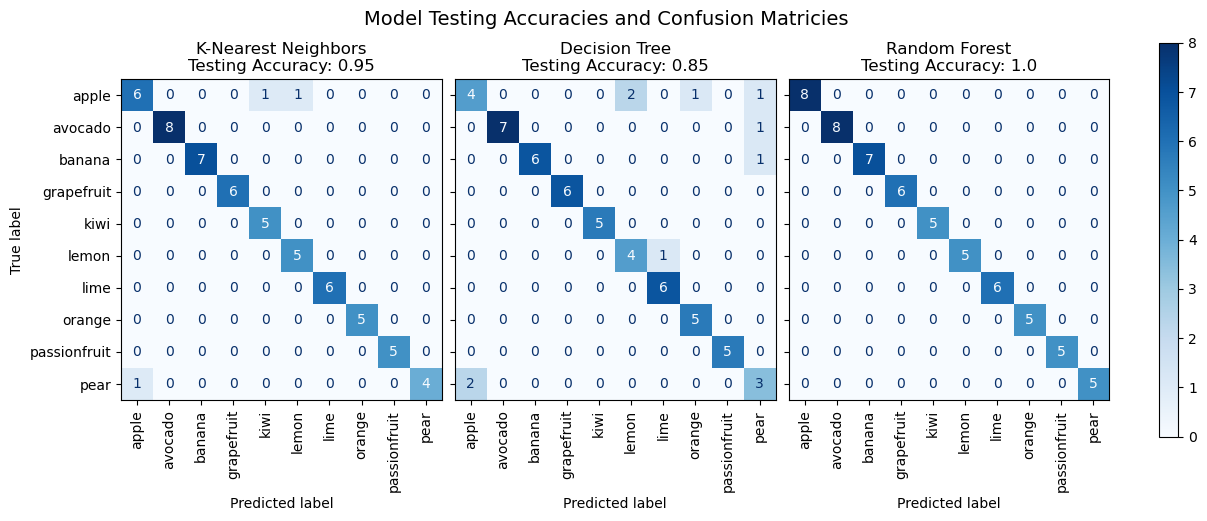

In [33]:
#specify predictors/n_components that performed best in cross-validation (same for all models)
preds = extensive_vars+raw_img_vars
preds_pca = (extensive_vars, raw_img_vars)
n_components = (2,10)
#specify models w/ hyperparameters that performed best in cross-validation
knn_model = KNeighborsClassifier(n_neighbors = 1)
dt_model = DecisionTreeClassifier(min_samples_leaf = 1, min_impurity_decrease = 0, random_state = 0)
rf_model = RandomForestClassifier(min_samples_leaf = 0.005, min_impurity_decrease = 0, random_state = 0, 
                                  n_estimators = 200)
#get test results
knn_test_results = get_test_results(train_df, test_df, preds, preds_pca, n_components, knn_model)
dt_test_results = get_test_results(train_df, test_df, preds, preds_pca, n_components, dt_model)
rf_test_results = get_test_results(train_df, test_df, preds, preds_pca, n_components, rf_model)
#plot testing accuracies and confusion matrices
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (12,5), sharey = True, constrained_layout = True)
plot_confusion_matrix(y_test = knn_test_results['y_test'], y_pred = knn_test_results['y_pred'], 
                      model_type = 'K-Nearest Neighbors', ax = ax1, ylabel = True)
plot_confusion_matrix(y_test = dt_test_results['y_test'], y_pred = dt_test_results['y_pred'], 
                      model_type = 'Decision Tree', ax = ax2, ylabel = False)
plot_confusion_matrix(y_test = rf_test_results['y_test'], y_pred = rf_test_results['y_pred'], 
                      model_type = 'Random Forest', ax = ax3, ylabel = False)
fig.colorbar(mpl.cm.ScalarMappable(norm = mpl.colors.Normalize(vmin = 0, vmax = 8), cmap = mpl.cm.Blues),
            ax = [ax1,ax2,ax3])
fig.suptitle('Model Testing Accuracies and Confusion Matricies', size = 14)
plt.show()

Consistent with the cross-validation results, the random forest performed best overall. It achieved 100 percent accuracy on the testing set, followed by KNN with 95 percent and the decision tree with 85 percent. The confusion matrices show that pears and apples proved challening for both KNN and the decision tree, which makes sense given that their weights, volumes, and colors tended to be similar in several cases. The decision tree made several mistakes beyond these two groups, including for avocados, bananas, and lemons.

### Model Interpretability

Many machine learning approaches provide way of interpreting the relationships between the predictors and the target variables. 

As an <a href="https://en.wikipedia.org/wiki/Instance-based_learning#:~:text=In%20machine%20learning%2C%20instance%2Dbased,have%20been%20stored%20in%20memory.">instance-based</a> method, KNN relies on the raw training data to make predictions, and does not produce an interpretable model.

In contrast, decision trees are highly interpretable. Tree plots are one way to visualize decision trees, and can serve as a map to determine how any new data point would be classified based on its predictor values. The below cell generates a tree plot for the best performing decision tree in this analysis, truncated to a depth of two splits. It shows that the tree makes the first split on the first PC from the image data, using a threshold value of 5.136. Based on this split alone, the right "children" -- those having a value greater than 5.136 for this variable -- are almost entirely avocados. The node containing these right children is split again, and its left children form the first leaf node. Any new data point with predictors that lead it to this leaf in the tree will be classified as avocados. The full version of this tree is somewhat unwieldy given its depth and the large number of classes it is trying to predict, but it can be viewed by setting the `max_depth` parameter in Scikit-Learn's `plot_tree( )` function to 10.

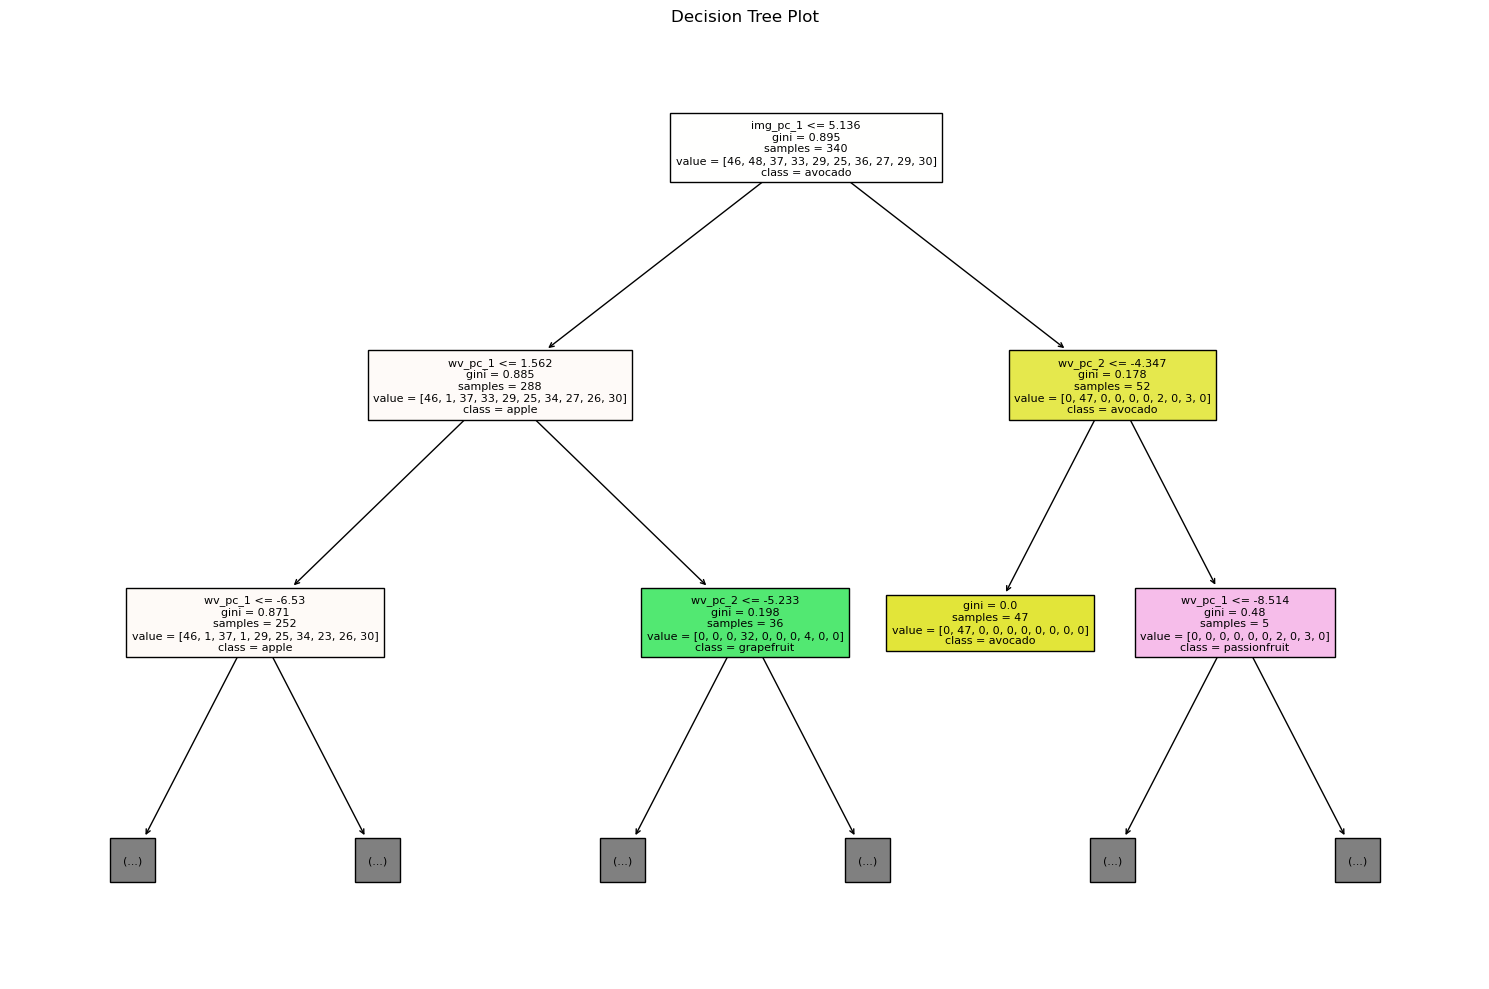

In [34]:
#plot decision tree
plt.figure(figsize = (15,10))
feature_names = ['img_pc_{}'.format(i) for i in range(1,11)]+['wv_pc_{}'.format(i) for i in range(1,3)]
plot_tree(dt_test_results['final_model'], max_depth = 2, feature_names = feature_names, 
          class_names = sorted_classes, fontsize = 8, filled = True)
plt.title('Decision Tree Plot')
plt.tight_layout()
plt.show()

Random forests are less interpretable than individual trees because there are simply too many trees to visualize. However, we can derive the relative importance of predictor features. The method built into Scikit-Learn's RandomForestClassifier used here computes importance as a function of the reduction in class impurity that results from splitting on the given predictor across the trees. This comes with some important caveats, but it is often a useful heuristic. The plot below shows that the first two PCs generated from the extensive variables and the first two PCs generated from the image data were the most important for making predictions.

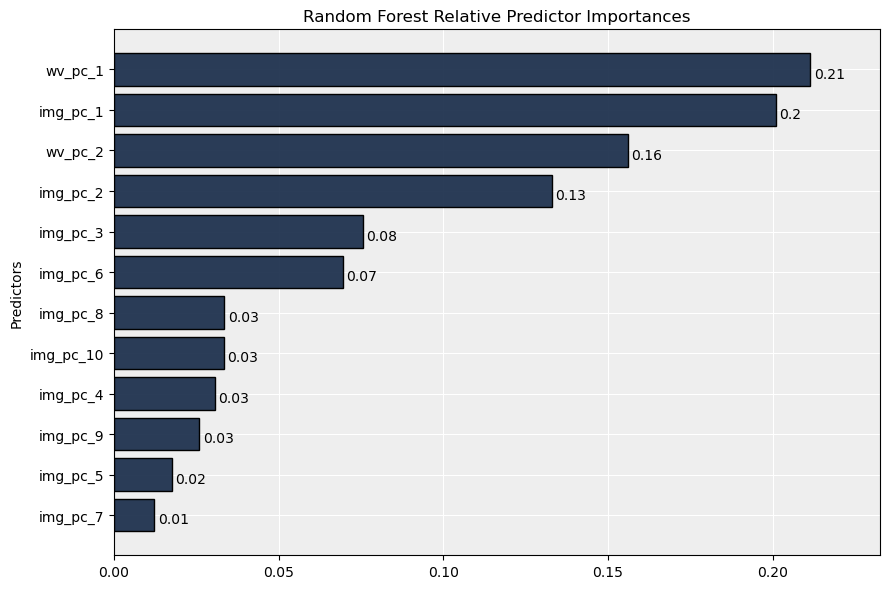

In [35]:
#plot random forest relative predictor importances
feature_names = ['img_pc_{}'.format(i) for i in range(1,11)]+['wv_pc_{}'.format(i) for i in range(1,3)]
feature_importances = rf_test_results['final_model'].feature_importances_
feature_names_sorted = [i[1] for i in sorted([(fi,fn) for fi,fn in zip(feature_importances,feature_names)])]
feature_importances_sorted = [i[0] for i in sorted([(fi,fn) for fi,fn in zip(feature_importances,feature_names)])]
plt.figure(figsize = (9,6))
ax = plt.axes()
ax.set_facecolor((200/255,200/255,200/255,0.3))
plt.grid(zorder = 0, color = 'white')
plt.barh(y = feature_names_sorted, width = feature_importances_sorted, color = db, edgecolor = 'black', 
         zorder = 100)
for y,x in enumerate(feature_importances_sorted):
    plt.text(x = x+0.001, y = y-0.2, s = round(x,2))
plt.xlim(0,max(feature_importances_sorted)*1.1)
plt.ylabel('Predictors')
plt.title('Random Forest Relative Predictor Importances')
plt.tight_layout()
plt.show()

## Summary

This notebook has touched on a number of key concepts and tools, from the basics of data exploration to training and evaluating alternative machine learning classifiers. Of the three machine learning methods examined here, the random forest model ultimately performed best in terms of cross-validation and testing accuracy. All three approaches were significantly improved through a process of experimentation with different transformations of the data as well as tuing the models' hyperparameters using cross-validation. To illustrate and quantify the value that this process has added, the below cell produces a visualization showing how each machine learning approach performs on the testing set with the raw predictors and default hyperparameters, compared to the final models selected in this analysis. 

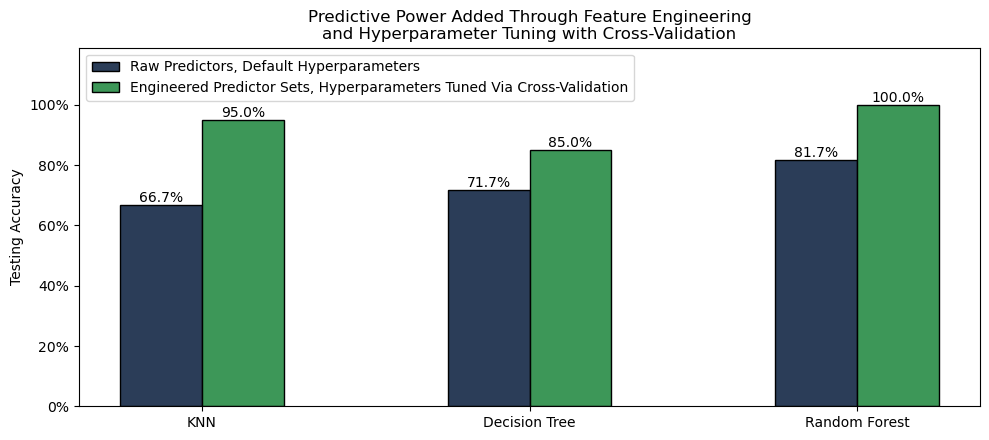

In [36]:
#how do all of the models do without feature engineering or hyperparamter tuning?
#get data
X_train, y_train = train_df[all_orig_pred_vars], train_df[target]
X_test, y_test = test_df[all_orig_pred_vars], test_df[target]
#specify models
model_names = ['KNN','Decision Tree','Random Forest']
models = [KNeighborsClassifier(), 
          DecisionTreeClassifier(random_state = 0), 
          RandomForestClassifier(random_state = 0)]
#get test accuracy for each model with raw predictors, no hyperparameter tuning
crude_acc = [np.mean(m.fit(X_train,y_train).predict(X_test)==y_test) for m in models]
#get testing accuracy from models with engineered feature set, hyperparams tuned with cross-validation
refined_acc = [knn_test_results['test_accuracy'],
               dt_test_results['test_accuracy'],
               rf_test_results['test_accuracy']]

#plot results
fig, ax = plt.subplots(1, 1, figsize = (10,4.5))
bar_width = 0.25
x_pos = np.array([0,1,2])
ax.bar(x_pos-bar_width/2, crude_acc, width = bar_width, label = 'Raw Predictors, Default Hyperparameters', 
       color = db, edgecolor = 'black')
ax.bar(x_pos+bar_width/2, refined_acc, width = bar_width, color = dg,  edgecolor = 'black',
       label = 'Engineered Predictor Sets, Hyperparameters Tuned Via Cross-Validation')
for x,y1,y2 in zip(x_pos,crude_acc,refined_acc):
    plt.text(x-bar_width/2, y1, s = str(round(100*y1,1))+'%', ha = 'center', va = 'bottom')
    plt.text(x+bar_width/2, y2, s = str(round(100*y2,1))+'%', ha = 'center', va = 'bottom')
ax.set_xticks(x_pos,model_names)
ax.set_ylim(0,1.19)
yticks = ax.get_yticks()
ax.set_yticks(yticks[:-1],['{}%'.format(round(100*i)) for i in yticks][:-1])
ax.legend(loc = 'upper left')
ax.set_ylabel('Testing Accuracy')
plt.title('Predictive Power Added Through Feature Engineering\nand Hyperparameter Tuning with Cross-Validation')
fig.tight_layout()
plt.show()

It is important to emphasize that we only explored a handful of different options with respect to our predictor sets, hyperparameters, data transformations, and other factors relevant to machine learning, which were not necessarily globally optimal. Readers are invited to experiment with alternative options and see how this impacts the results. Please feel free to let me know what you find, or share any other feedback related to this notebook.

## 
## 
## 
## 
## Examples

<a id='pca_ex'></a>
### PCA Example ([Back](#pca))
Here we give an example of PCA when applied to just two of our highly correlated image predictors -- `r_55_55` and `r_55_56` -- to simplify the problem and help further strengthen our intuition about what PCA does. 

The below code calls a previously-defined helper function, which implements PCA on these two variables and generates three visualizations. The first shows the data with respect the original variables. The red arrows show a new <a href="https://en.wikipedia.org/wiki/Orthogonality">orthogonal</a> coordinate system that PCA will use to represent the data. As is clear from the plot, the data varies most greatly along the PC1 axis, and very little along the PC2 axis. PC1 accounts for 96 percent of the variance in this data, while PC2 only accounts for 4 percent. The second and third plots show the data distributed according to PC1 and PC2 with respect to the fruit types we are trying to predict. Neither one appears to be a great predictor, but PC1 certainly seems to contain more relevant information for prediction when compared to PC2, where all of the classes are virtually indistinguishable. Applying this to all of the image data, we hope to leverage this principle on a larger scale and get more meaningful results.

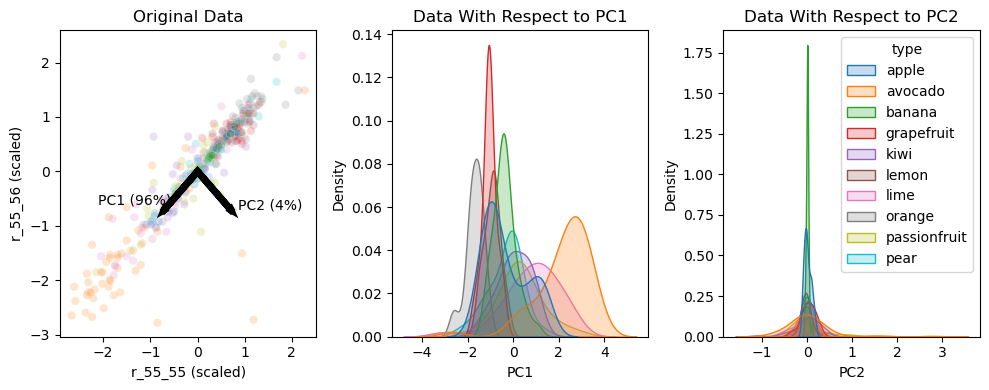

In [37]:
plot_pca_example1()

If PC1 contains much of the information from the original two variables and PC2 does not, we would expect that PC1 would be highly correlated with both, while PC2 would not. The helper function called in the below cell generates visualizations demonstrating that this is indeed the case. 

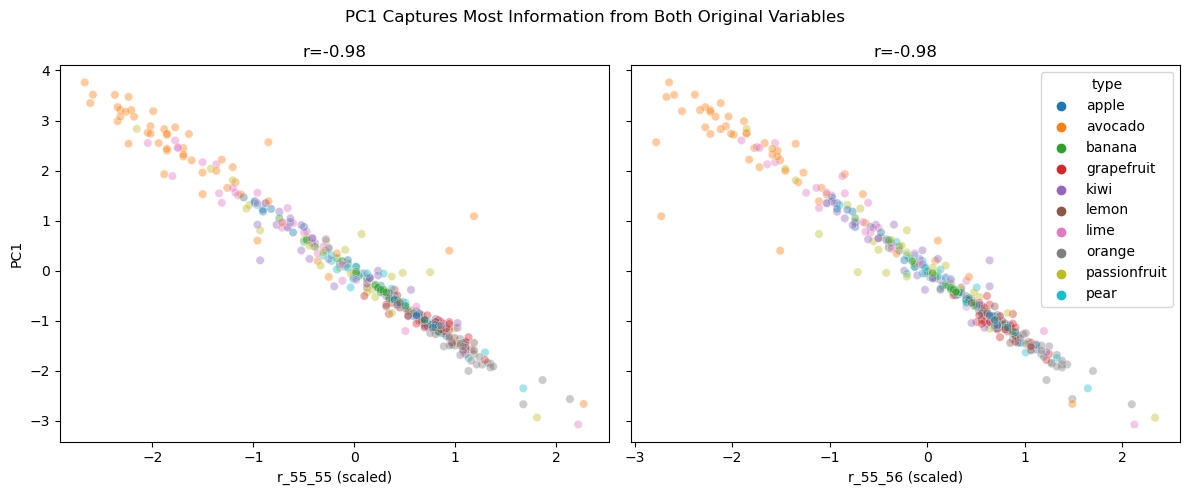

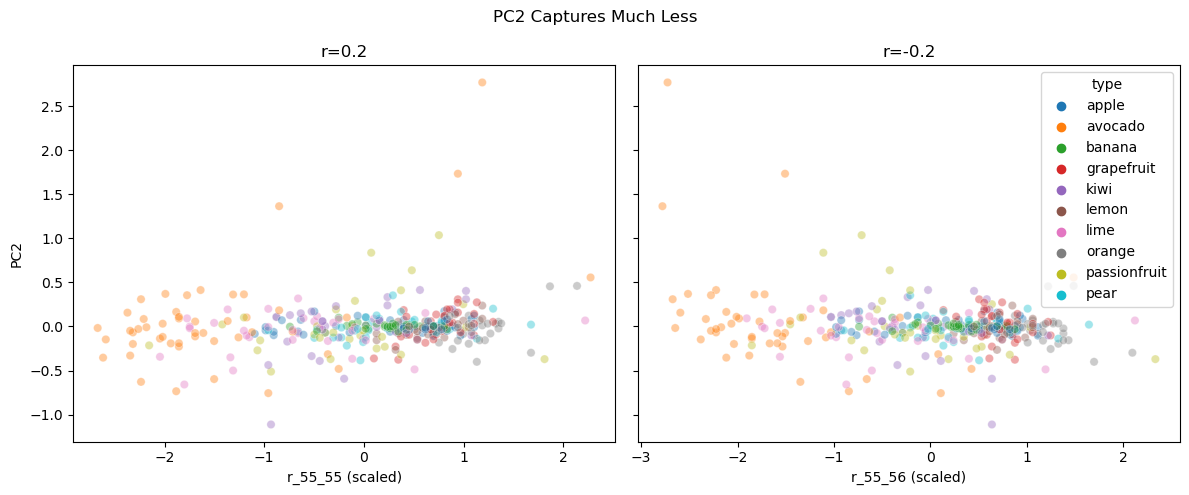

In [38]:
plot_pca_example2()

<a id='knn_toy'></a>
### KNN Toy Example ([Back](#knn))

The example below uses toy data to show how a new data point is assigned to a class with KNN where k=3 using an L2 distance metric. We are given a set of training data points in the visual on the left, and then in the middle visualization we are given a new data point of an unknown class. The visual on the right shows that the algorithm assigns the new data point to "Class 1" because two out of its three nearest neighbors in the predictor space belong to that class.

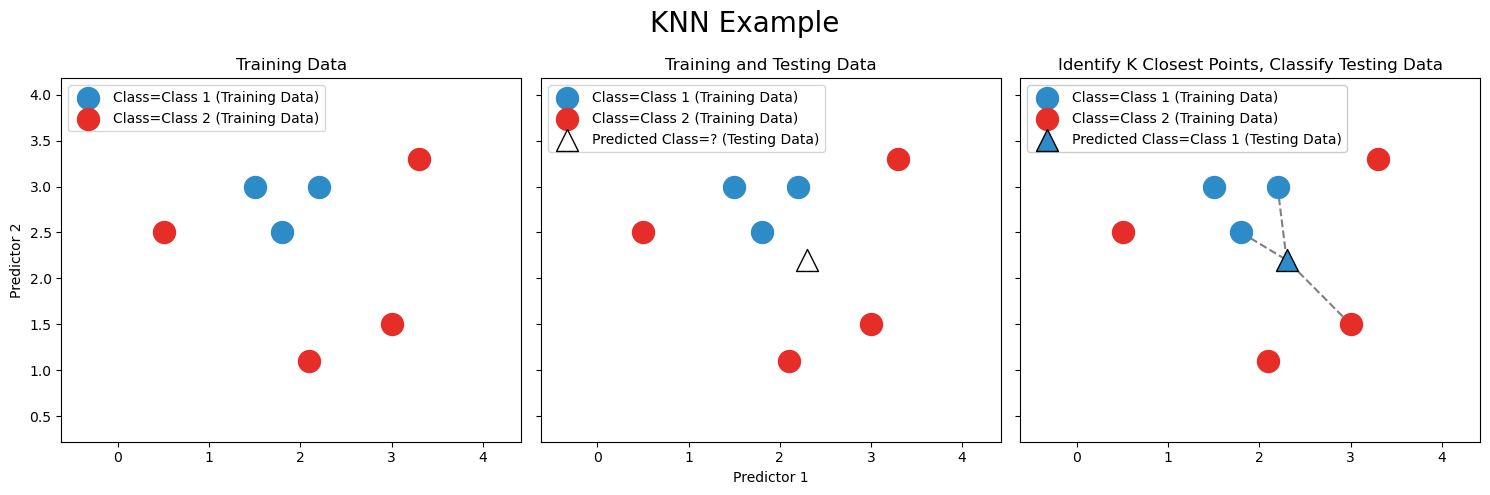

In [39]:
plot_knn_toy(x_train_toy, y_train_toy, x_test_toy, k = 3)

<a id='tree_ex'></a>
### Decision Tree Toy Example ([Back](#tree))

The below example shows how a decision tree (limited to three leaf nodes and using gini impurity) might classify a new data point using the same toy dataset that was used for KNN above. The visual on the right shows that it partitions the data based on whether it has a Predictor 2 value of greater than 2. If it does not, it will be classified as belonging to Class 2. If it does, the model will then partition it again based on whether it has a Predictor 1 value greater than 1. If so, it is assigned to Class 1. Otherwise, it is assigned to Class 2. As with the KNN example, the tree assigned the new data point to Class 1. Note that a random seed is included for breaking ties when multiple splits result in the same amount of purity.

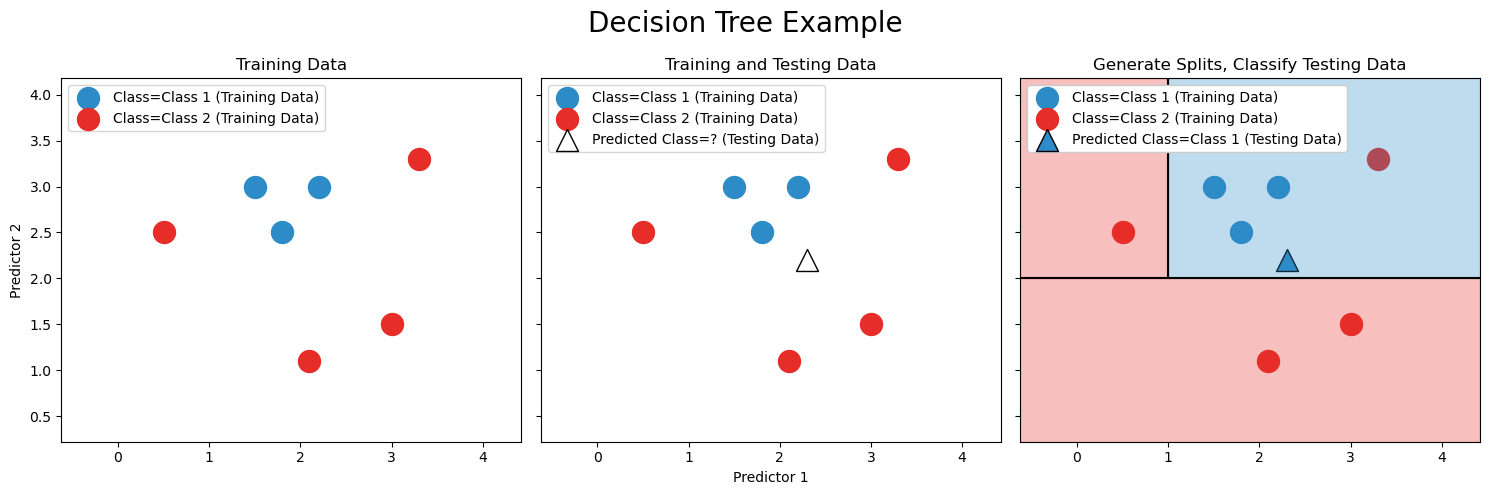

In [40]:
plot_dt_toy(x_train_toy,y_train_toy,x_test_toy,seed = 0)

The above decision tree can also be rendered as a tree plot, which is shown below in case readers find this representation more intuitive. 

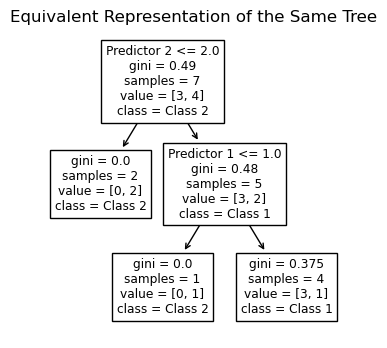

In [41]:
#plot alternative rendering of tree
plt.figure(figsize = (4,4))
tree = DecisionTreeClassifier(random_state = 0, max_depth = 2).fit(x_train_toy,y_train_toy)
plot_tree(tree, feature_names = ['Predictor 1','Predictor 2'], class_names = ['Class 1', 'Class 2'])
plt.title('Equivalent Representation of the Same Tree')
plt.show()

<a id='forest_ex'></a>
### Random Forest Toy Example ([Back](#forest))

The below example shows three trees fit to different random samples of the training data points, each accounting for about 70 percent (or five out of seven) of the the toy training data. Two of the trees predict that the testing data point belongs to Class 1 and one predicts that it belongs to Class 2. The final prediction is therefore Class 1. 

(Note: Since we only have two predictors for this toy dataset, each tree in this particular random forest uses both predictors as candidates for splitting, even though a random forest would typically select a random subset of predictors for each tree. In addition, random forests usually use a <a href = "https://en.wikipedia.org/wiki/Bootstrapping_(statistics)">bootstrap</a> sampling method with replacement for selecting each tree's training data, but for purposes of visualization the below forest selected training data without replacement).

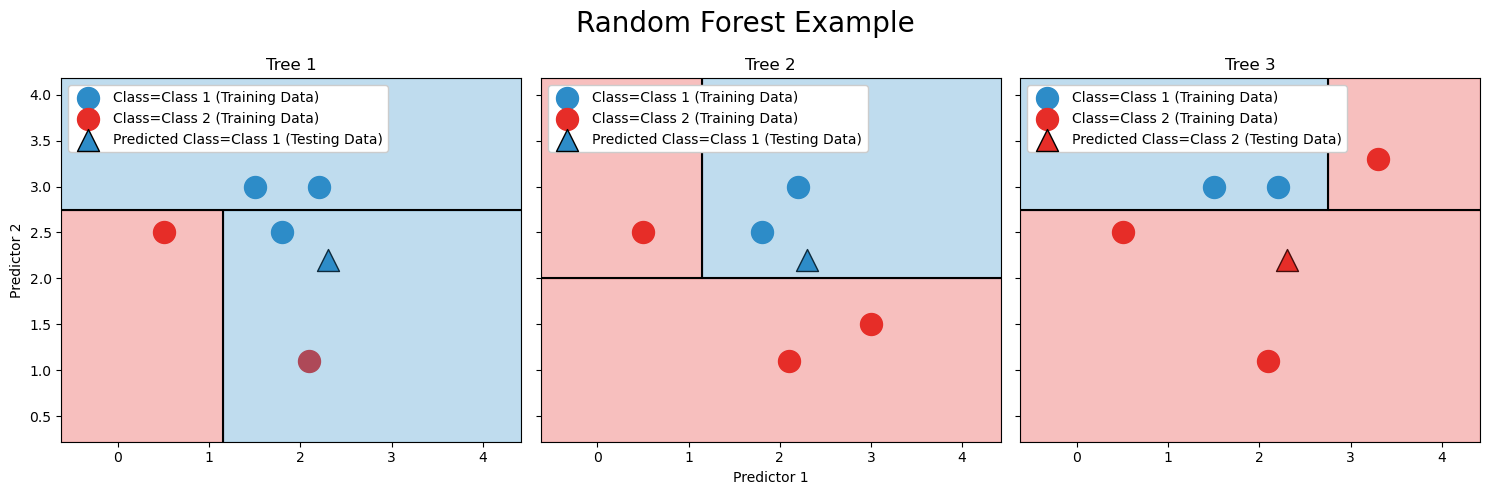

In [42]:
plot_rf_toy(x_train_toy,y_train_toy,x_test_toy,seed = 0)

<a id='pca_tree_ex'></a>
### PCA Rotation for Tree Classifiers Example ([Back](#pca_tree))

To demonstrate how a decision tree can potentially be made more efficient at classification by rotating the data when there is a diagonal decision boundary, we will use a pseudo-random toy dataset with two classes. The below cell generates the toy dataset, splits it into training and test sets, and plots the training set. Note that the classes can be very easily separated with a diagonal line. 

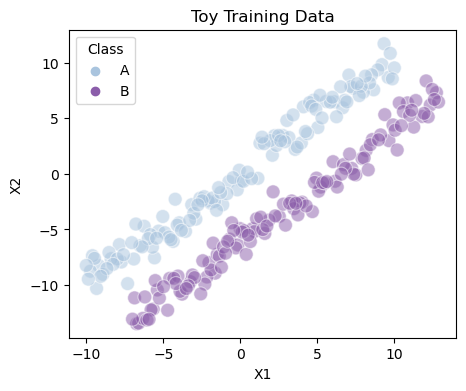

In [43]:
#generate toy data
toy_data = get_tree_pca_toy_data()
#train-test split
train, test = train_test_split(toy_data,
                               shuffle = True, 
                               stratify = toy_data['Class'], 
                               test_size = 0.20,
                               random_state = 0)
X_train, y_train = train[['X1','X2']], train['Class']
X_test, y_test  = test[['X1','X2']], test['Class']
#plot training data
plt.figure(figsize = (5,4))
sns.scatterplot(x = 'X1', y = 'X2', hue = 'Class', data = train, s = 100, alpha = 0.5, palette = 'BuPu')
plt.title('Toy Training Data')
plt.show()

The below cell builds a decision tree classifier on the raw data, without applying any PCA transformation. It optimizes the depth of the tree using stratified seven-fold cross-validation. The best mean cross-validation accuracy score is 92 percent when the depth of the tree is eight, and this tree achieves an accuracy of 93 percent on the testing set.

In [44]:
#build model on untransformed toy data with diagonal boundary
#specify cv method
cv = StratifiedKFold(n_splits = 7, shuffle = True, random_state = 0)
#specify hyperparameter(s) for tuning
params = {'max_depth': [i for i in range(1,31)]}
#specify gridsearch using pca
gridsearch = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0), 
                          param_grid = params, cv = cv)
#fit
gridsearch.fit(X_train, y_train)
#print results
print('Best params:',gridsearch.best_params_)
print('Best CV accuracy:',round(gridsearch.best_score_,2))
print('Accuracy on test set:',round(np.mean(gridsearch.predict(X_test) == y_test),3))

cv_results = pd.DataFrame(gridsearch.cv_results_)
best_cv_results = cv_results[cv_results['params']==gridsearch.best_params_]
split_result_cols = [i for i in best_cv_results.columns if re.match(r'split[0-9]',i)]
split_results = np.array(best_cv_results[split_result_cols].transpose()).flatten()

Best params: {'max_depth': 8}
Best CV accuracy: 0.92
Accuracy on test set: 0.933


Let's visualize this model and inspect what the issue might be. The below cell calls a function imported from the toy.py script, which plots the tree on the training and testing data. Here we can see clearly that the decision boundary looks more like a staircase than a smooth diagonal, causing it to have a very small margin with many data points in various regions, and even to misclassify several points. 

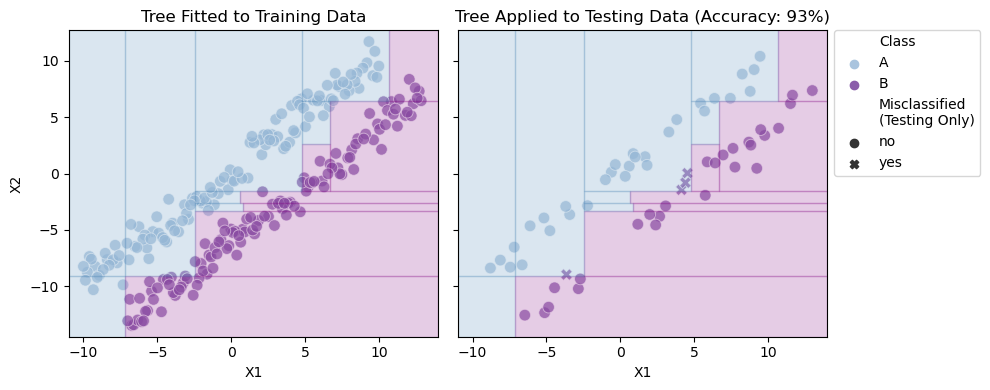

In [45]:
#(Note that this plotting function will not work on other data. It was written as a function merely to save space.)
plot_non_pca_model_ex(gridsearch, toy_data, train, test, X_test, y_test)

Now let's build a tree using the same procedures as above, except we will rotate the data using PCA. The below cell shows that this approach achieves 100 percent mean cross-validation accuracy using a tree that only splits the data once, and this model also yields 100 percent accuracy on the testing set. 

In [46]:
#build model on toy data rotated with PCA
#specify cv method
cv = StratifiedKFold(n_splits = 7, shuffle = True, random_state = 0)
#specify hyperparameter(s) for tuning
pca_params = {'model__max_depth': [i for i in range(1,31)],
              'PCA__n_components':[2]}
#build pipeline with PCA
pca_pipeline_steps = [('scale', StandardScaler()),
                       ('PCA', PCA(svd_solver = 'full')),
                       ('model',DecisionTreeClassifier(random_state = 0))]
pca_pipeline = Pipeline(steps = pca_pipeline_steps)
#specify gridsearch using pca
gridsearch_pca = GridSearchCV(estimator = pca_pipeline, param_grid = pca_params, cv = cv)
#fit
gridsearch_pca.fit(X_train, y_train)
#print results
print('Best params:',gridsearch_pca.best_params_)
print('Best CV accuracy:',round(gridsearch_pca.best_score_,3))
print('Accuracy on test set:',round(np.mean(gridsearch_pca.predict(X_test) == y_test),3))
#store cv data
cv_results_pca = pd.DataFrame(gridsearch_pca.cv_results_)
best_cv_results_pca = cv_results_pca[cv_results_pca['params']==gridsearch_pca.best_params_]
split_result_cols_pca = [i for i in best_cv_results_pca.columns if re.match(r'split[0-9]',i)]
split_results_pca = np.array(best_cv_results_pca[split_result_cols_pca].transpose()).flatten()

Best params: {'PCA__n_components': 2, 'model__max_depth': 1}
Best CV accuracy: 1.0
Accuracy on test set: 1.0


First, let's look at how the data was transformed using PCA. The below cell calls another function imported from the toy.py script, which shows the original training data, the new PCA coordinate system overlying the scaled data, and the data that has been rotated via the PCA transformation. The main thing to observe is that the diagonal decision boundary is now horizontal.

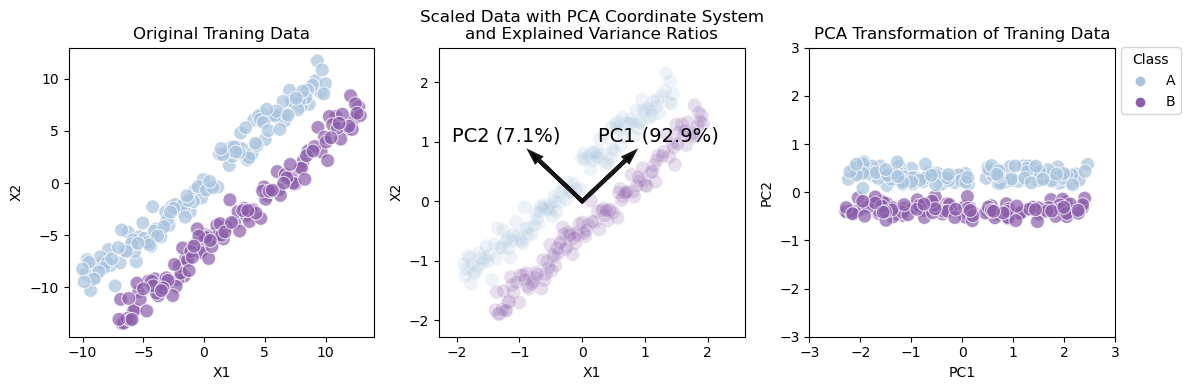

In [47]:
plot_pca_transformation_tree_ex(gridsearch_pca, train, test, X_train, y_train, X_test, y_test)

Now let's see the model that was built on the PCA-transformed data. The below cell calls another function imported from the toy.py script, which demonstrates the superiority of this new model in terms of both simplicity and accuracy. Of course, this is an ideal example, and PCA rotation is not always the best approach in these cases, but the point here is to illustrate that it is a method worth exploring. 

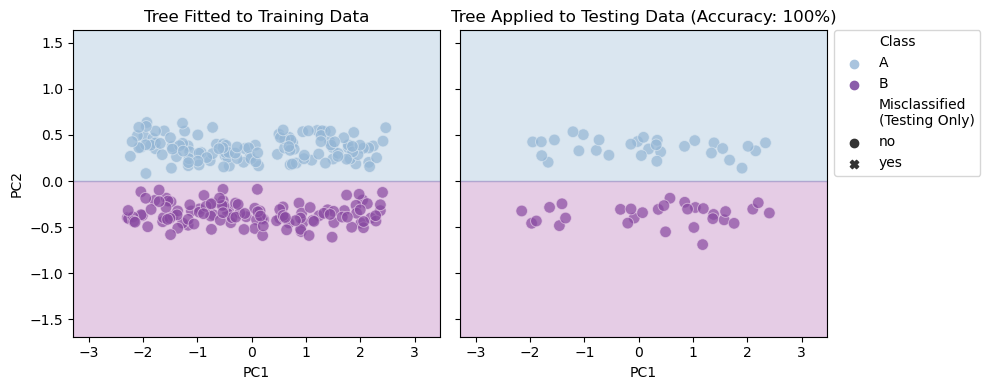

In [48]:
#(Note that this plotting function will not work on other data. It was written as a function merely to save space.)
plot_pca_model_ex(gridsearch_pca, X_train, y_train, X_test, y_test)

# References

<a id='pca_ref'></a>
### PCA References ([Back](#pca))

- Bishop, Christopher M. 2006. <i>Pattern Recognition and Machine Learning</i>. New York: Springer, pp. 561-570.

- Hotelling, Harold. 1933. "Analysis of a complex of statistical variables into principal components." <i>Journal of Educational Psychology</i>, 24(6), 417–441. https://doi.org/10.1037/h0071325

- Jolliffe, Ian T. and Cadima Jorge. 2016. "Principal component analysis: a review and recent developments." <i>Phil. Trans. R. Soc. A.</i> https://doi.org/10.1098/rsta.2015.0202

- Shlens, Jonathon. 2014. "A Tutorial on Principal Component Analysis." https://doi.org/10.48550/arxiv.1404.1100

- Zheng, Jianwei and Cyril Rakovski. 2021. "On the Application of Principal Component Analysis to Classification Problems." <i>Data Science Journal</i>, 20: 26. http://doi.org/10.5334/dsj-2021-026

- Kuncheva, Ludmila I., Juan J. Rodríguez, and Carlos J. Alonso. 2006. "Rotation Forest: A New Classifier Ensemble Method." <i>IEEE Trans Pattern Anal Mach Intell.</i>, 28(10). http://doi.org/10.1109/TPAMI.2006.211

- Scikit-Learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

<a id='knn_ref'></a>
### KNN References ([Back](#knn))

- Bishop, Christopher M. 2006. <i>Pattern Recognition and Machine Learning</i>. New York: Springer, pp. 124-127.

- Cover, Thomas M. and Peter E. Hart. 1967. "Nearest Neighbor Pattern Classification." IEEE Transactions on Information Theory, 13(1), 21-27. https://doi.org/10.1109/TIT.1967.1053964

- Cunningham, Padraig and Sarah Jane Delany. 2020. "k-Nearest Neighbour Classifiers: 2nd Edition (with Python Examples)."   https://doi.org/10.48550/arXiv.2004.04523 

- Scikit-Learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

<a id='tree_ref'></a>
### Decision Tree References ([Back](#tree))

- Bishop, Christopher M. 2006. <i>Pattern Recognition and Machine Learning</i>. New York: Springer, pp. 663-666.
- Hastie, Trevor, Robert Tibshirani, and Jerome Friedman. 2016. <i>The Elements of Statistical Learning: Data Mining, Inference, and Prediction (Second Edition).</i> New York: Springer, pp. 305-317.
- Loh, W. Y. 2014. "Fifty Years of Classification and Regression Trees" <i>International Statistical Review</i> 82(3), 329–348. https://doi.org/10.1111/insr.12016.
- Patel, Harsh and Purvi Prajapati. 2018. "Study and Analysis of Decision Tree Based Classification Algorithms." 
<i>International Journal of Computer sciences and Engineering</i>, 6(10), 74-78.
https://doi.org/10.26438/ijcse/v6i10.7478.
- Scikit-Learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

<a id='forest_ref'></a>
### Random Forest References ([Back](#forest))

- Breiman, L. 2001. "Random Forests." <i>Machine Learning</i> 45, 5–32. https://doi.org/10.1023/A:1010933404324.
- Hastie, Trevor, Robert Tibshirani, and Jerome Friedman. 2016. <i>The Elements of Statistical Learning: Data Mining, Inference, and Prediction (Second Edition).</i> New York: Springer, pp. 587-603.
- Ho, Tin Kam. 1995. "Random Decision Forests." <i>Proceedings of 3rd international conference on document analysis and recognition</i>, 278–282.  Accessed via https://web.archive.org/web/20160417030218/http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf on 20 February 2023.
- Scikit-Learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html